# Business Problem Definition + Data Source Description

We aim to understand the impact of various factors such as weather and park events being held in NYC on people’s preferences for transportation. By integrating data from NYC taxi records, citibikes data, weather data, and NYC park events data, our analysis aims to achieve several objectives. 

• Conduct a thorough examination of New Yorkers' transportation preferences across different modes of transit, spanning the years from 2016 to 2018.

• Identify monthly and hourly trends for weather and events from 2016 through to 2018.

Our data sources consist of a collection of datasets that provide insights into various aspects of NYC's transportation landscape. These include trip records from NYC Taxi and Limousine Commission (TLC) for Yellow and Green taxis, spanning from 2014 to 2023, daily Citi bike trip data from 2013 to 2018, weather data sourced from Kaggle covering over a century and collected at Central Park or the automated station at Belvedere Castle, and NYC Parks Events dataset sourced from NYC Open Data spanning from 2013 to 2023.

# Summary

Through the analysis in the notebook, we seeked to gain a better understanding of the various datasets which are relevant in figuring out the external factors that influence customer choice between different ride types. 

These are our main findings:

• Over the years 2016 to 2018, ride preferences in New York City have shifted, with a decline in the use of traditional green and yellow taxis, likely due to the rise of ride-hailing services such as Uber and Lyft. 

• In contrast, Citi Bikes gained popularity, especially during summer months, reflecting both an increased interest in biking and the influence of seasonal weather patterns. 

• The analysis reveals that taxis and Citi Bikes peak in usage around traditional commute times, but taxis maintain higher night-time usage, suggesting a preference for secure and private transport after dark. 

• Additionally, fare trends suggest higher taxi demand in the morning, with yellow taxis consistently more expensive than green ones. 

• Park events are most frequently organized in the warmer months, peaking before noon and experiencing a resurgence in late afternoons and evenings. 

• In terms of weather, snowfall is mainly concentrated in the winter months, while precipitation is more variable, showing no direct correlation with snowfall, hinting at a complex interaction of climatic factors beyond just seasonal variations.

# Data loading + Preprocessing

## Data Paths

These are the relevant paths to the data in our Google Cloud Storage.

In [1]:
path_green = "gs://ba843-project/notebooks/jupyter/data/nyc-taxi/green/green-*"
path_yellow = "gs://ba843-project/notebooks/jupyter/data/nyc-taxi/yellow/yellow-*"
trips = "gs://ba843-project/notebooks/jupyter/data/nyc-citibike/nyc-bike-*.csv"
events_list = "gs://ba843-project/notebooks/jupyter/data/nyc-events/NYC_Parks_Events_Listing_Event_Listing.csv"
events_loc = "gs://ba843-project/notebooks/jupyter/data/nyc-events/NYC_Parks_Events_Listing_Event_Locations.csv"
path_weather =  "gs://ba843-project/notebooks/jupyter/data/nyc-weather/NYC_Central_Park_weather_1869-2022.csv"

## Green Taxi Reading

In this section, we will read the raw files that contain green taxi data from 2016 to 2018.

In [2]:
green_taxi = spark.read.csv(path_green, header=True, inferSchema=True)

In [3]:
green_taxi = green_taxi.dropDuplicates()

In [4]:
green_taxi.cache()

DataFrame[vendor_id: int, pickup_datetime: timestamp, dropoff_datetime: timestamp, store_and_fwd_flag: string, rate_code: double, passenger_count: int, trip_distance: double, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, ehail_fee: double, airport_fee: string, total_amount: double, payment_type: double, distance_between_service: string, time_between_service: string, trip_type: double, imp_surcharge: double, pickup_location_id: int, dropoff_location_id: int, data_file_year: int, data_file_month: int]

In [5]:
from pyspark.sql import functions as F
green_taxi = green_taxi.where(F.col("pickup_datetime").isNotNull())\
                       .withColumn("year", F.year("pickup_datetime"))\
                       .withColumn("month", F.month("pickup_datetime"))\
                       .withColumn("hour", F.hour("pickup_datetime"))

In [6]:
green_taxi = green_taxi.withColumn("label", F.lit("green_taxi"))

In [7]:
green_taxi.printSchema()

root
 |-- vendor_id: integer (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- rate_code: double (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- ehail_fee: double (nullable = true)
 |-- airport_fee: string (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: double (nullable = true)
 |-- distance_between_service: string (nullable = true)
 |-- time_between_service: string (nullable = true)
 |-- trip_type: double (nullable = true)
 |-- imp_surcharge: double (nullable = true)
 |-- pickup_location_id: integer (nullable = true)
 |-- dropoff_location_id: integer (nullable = 

## Yellow Taxi Reading

In this section, we will read the raw files that contain yellow taxi data from 2016 to 2018.

In [8]:
yellow_taxi = spark.read.csv(path_yellow, header=True, inferSchema=True)

In [9]:
yellow_taxi = yellow_taxi.dropDuplicates()

In [10]:
yellow_taxi.cache()

DataFrame[vendor_id: int, pickup_datetime: timestamp, dropoff_datetime: timestamp, passenger_count: int, trip_distance: double, rate_code: double, store_and_fwd_flag: string, payment_type: int, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, imp_surcharge: double, airport_fee: int, total_amount: double, pickup_location_id: int, dropoff_location_id: int, data_file_year: int, data_file_month: int]

In [11]:
from pyspark.sql import functions as F
yellow_taxi = yellow_taxi.where(F.col("pickup_datetime").isNotNull())\
                       .withColumn("year", F.year("pickup_datetime"))\
                       .withColumn("month", F.month("pickup_datetime"))\
                       .withColumn("hour", F.hour("pickup_datetime"))

In [12]:
yellow_taxi = yellow_taxi.withColumn("label", F.lit("yellow_taxi"))

## Bike Trips Reading

In this section, we will read the raw files that contain Citi bike data from 2016 to 2018. There are two notes to this data: 1) the data is only available until May 31, 2018. 2) there is missing data between October 2016 and February 2016.

In [2]:
df_trips = spark.read.csv(path = trips, header=True)
df_trips.schema

StructType([StructField('tripduration', StringType(), True), StructField('starttime', StringType(), True), StructField('stoptime', StringType(), True), StructField('start_station_id', StringType(), True), StructField('start_station_name', StringType(), True), StructField('start_station_latitude', StringType(), True), StructField('start_station_longitude', StringType(), True), StructField('end_station_id', StringType(), True), StructField('end_station_name', StringType(), True), StructField('end_station_latitude', StringType(), True), StructField('end_station_longitude', StringType(), True), StructField('bikeid', StringType(), True), StructField('usertype', StringType(), True), StructField('birth_year', StringType(), True), StructField('gender', StringType(), True), StructField('customer_plan', StringType(), True)])

In [9]:
from pyspark.sql.types import StructType, StructField, StringType, LongType, FloatType, IntegerType, TimestampType, BooleanType

Manual_datatype = StructType([StructField('tripduration', IntegerType(), True),
                              StructField('starttime', TimestampType(), True),
                              StructField('stoptime', TimestampType(), True),
                              StructField('start_station_id', IntegerType(), True),
                              StructField('start_station_name', StringType(), True),
                              StructField('start_station_latitude', FloatType(), True),
                              StructField('start_station_longitude', FloatType(), True),
                              StructField('end_station_id', IntegerType(), True),
                              StructField('end_station_name', StringType(), True),
                              StructField('end_station_latitude', FloatType(), True),
                              StructField('end_station_longitude', FloatType(), True),
                              StructField('bikeid', IntegerType(), True),
                              StructField('usertype', StringType(), True),
                              StructField('birth_year', IntegerType(), True),
                              StructField('gender', StringType(), True),
                              StructField('customer_plan', StringType(), True)])
df_trips = spark.read.format("csv").schema(Manual_datatype).option("header", "true").option("quote", '"').option("escape",'"').option("nullValue","NA").load(trips)

In [4]:
# drop off the non-necessary columns
df_trips = df_trips.drop('customer_plan')

In [5]:
# filter out the rows which all the columns are null
df_trips = df_trips.na.drop("all", subset=["starttime", "stoptime","bikeid"])

In [13]:
# filter the data: remain 2016 ~ 2018
from pyspark.sql.functions import year, col
df_trips = df_trips.where((year(col("starttime")) <= 2018) & (year(col("starttime")) >= 2016))

In [14]:
# Change timestamp data into readable format (starttime, stoptime, tripduration)
from pyspark.sql.functions import date_format, from_unixtime, lit, to_date

df_trips = df_trips.withColumn('starttime_c', date_format('starttime', 'yyyy-MM-dd EEEE hh:mm:ss a')) \
                   .withColumn('stoptime_c', date_format('stoptime', 'yyyy-MM-dd EEEE hh:mm:ss a')) \
                   .withColumn('tripduration_hh/mm', from_unixtime('tripduration', 'HH:mm:ss')) \
                   .withColumn("label",lit("bike")) \
                   .withColumn("date",to_date("starttime"))
df_trips.limit(5).toPandas()

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,bikeid,usertype,birth_year,gender,customer_plan,starttime_c,stoptime_c,tripduration_hh/mm,label,date
0,981,2016-08-17 18:29:16.000,2016-08-17 18:45:37.000,457,Broadway & W 58 St,40.766953,-73.981697,3169,Riverside Dr & W 82 St,40.787209,...,16136,Subscriber,1950,male,,2016-08-17 Wednesday 06:29:16 PM,2016-08-17 Wednesday 06:45:37 PM,00:16:21,bike,2016-08-17
1,1172,2018-04-03 09:08:54.171,2018-04-03 09:28:26.766,229,Great Jones St,40.727436,-73.993790,232,Cadman Plaza E & Tillary St,40.695976,...,29760,Subscriber,1949,male,,2018-04-03 Tuesday 09:08:54 AM,2018-04-03 Tuesday 09:28:26 AM,00:19:32,bike,2018-04-03
2,130,2018-05-30 12:36:16.083,2018-05-30 12:38:26.542,358,Christopher St & Greenwich St,40.732914,-74.007111,346,Bank St & Hudson St,40.736530,...,26631,Subscriber,1952,male,,2018-05-30 Wednesday 12:36:16 PM,2018-05-30 Wednesday 12:38:26 PM,00:02:10,bike,2018-05-30
3,827,2017-11-03 20:23:46.000,2017-11-03 20:37:34.000,2012,E 27 St & 1 Ave,40.739445,-73.976807,383,Greenwich Ave & Charles St,40.735237,...,32418,Subscriber,1952,male,,2017-11-03 Friday 08:23:46 PM,2017-11-03 Friday 08:37:34 PM,00:13:47,bike,2017-11-03
4,629,2018-03-30 15:56:57.484,2018-03-30 16:07:26.982,394,E 9 St & Avenue C,40.725212,-73.977684,252,MacDougal St & Washington Sq,40.732265,...,25324,Subscriber,1950,male,,2018-03-30 Friday 03:56:57 PM,2018-03-30 Friday 04:07:26 PM,00:10:29,bike,2018-03-30


In [8]:
df_trips.cache()

DataFrame[tripduration: int, starttime: timestamp, stoptime: timestamp, start_station_id: int, start_station_name: string, start_station_latitude: float, start_station_longitude: float, end_station_id: int, end_station_name: string, end_station_latitude: float, end_station_longitude: float, bikeid: int, usertype: string, birth_year: int, gender: string, starttime_c: string, stoptime_c: string, tripduration_hh/mm: string, label: string, date: date]

## DF Definition (Green, Yellow, Citibikes)

Here, we are selecting the columns we need for the datasets mentioned above. We only chose the ones we needed for our analysis so that we could run our Spark code as efficiently as possible.

In [20]:
from pyspark.sql.functions import count, month, hour

df_citibike = df_trips.where(col("starttime").isNotNull()) \
                      .select(year("starttime").alias("year"),
                              month("starttime").alias("month"),
                              hour("starttime").alias("hour"),
                              "label")

In [21]:
df_green = green_taxi.select("year","month","hour","label","total_amount")
df_yellow = yellow_taxi.select("year","month","hour","label","total_amount")

## Events Reading

In this section, we will read the raw files that contain event listing and location data. We will filter the data to include the years 2016 to 2018 only.

In [10]:
# event listing
listing_schema = StructType([
    StructField("event_id", IntegerType(), True),
    StructField("title", StringType(), True),
    StructField("date", StringType(), True),
    StructField("start_time", StringType(), True),
    StructField("end_time", StringType(), True)
])

In [11]:
listing = spark.read.csv(events_list, header=True, schema=listing_schema)

In [15]:
### CHATGPT

from pyspark.sql.functions import to_date, to_timestamp, concat_ws

listing = listing.withColumn("date", to_date(col("date"), "MM/dd/yyyy"))

listing = listing.withColumn(
    "start_datetime",
    to_timestamp(concat_ws(" ", col("date"), col("start_time")), "yyyy-MM-dd HH:mm"))

listing = listing.withColumn(
    "end_datetime",
    to_timestamp(concat_ws(" ", col("date"), col("end_time")), "yyyy-MM-dd HH:mm"))

listing.limit(3).toPandas()

,event_id,title,date,start_time,end_time,start_datetime,end_datetime
0,173635,Central Park Tour: Iconic Views of Central Park,2018-10-21,11:00,12:30,2018-10-21 11:00:00,2018-10-21 12:30:00
1,156947,Birding Jamaica Bay,2017-12-23,13:00,14:30,2017-12-23 13:00:00,2017-12-23 14:30:00
2,120964,Halloweenie Lunch,2015-10-30,12:00,14:00,2015-10-30 12:00:00,2015-10-30 14:00:00


In [16]:
# Drop rows where any column value is null
listing = listing.dropna()

# Drop duplicate event id's
listing = listing.dropDuplicates(['event_id'])

In [17]:
# location data
from pyspark.sql.types import DoubleType

location_schema = StructType([
    StructField("event_id", IntegerType(), True),
    StructField("name", StringType(), True),
    StructField("park_id", StringType(), True),
    StructField("lat", DoubleType(), True),
    StructField("long", DoubleType(), True),
    StructField("address", StringType(), True),
    StructField("zip", StringType(), True)
])

In [18]:
locations = spark.read.csv(events_loc, header=True,schema=location_schema)

In [19]:
#Dropping subset = lat
locations = locations.dropna(subset=['lat'])

#Dropping duplicates
locations = locations.dropDuplicates(['event_id'])

In [20]:
# join listing and location datas
events = listing.join(locations, on='event_id', how='inner').drop('park_id', 'address','name')

In [21]:
from pyspark.sql.functions import year, col

events = events.filter(
    (year(col("date")) >= 2016) & 
    (year(col("date")) <= 2018)
)

events = events.withColumnRenamed("date","date_event")
events.limit(3).toPandas()

,event_id,title,date_event,start_time,end_time,start_datetime,end_datetime,lat,long,zip
0,81149,"Shape Up NYC: Stretching, Toning, Relaxation",2016-01-07,10:00,11:00,2016-01-07 10:00:00,2016-01-07 11:00:00,40.865002,-73.894699,None
1,82026,Seasonal Crafts,2016-01-15,14:00,15:30,2016-01-15 14:00:00,2016-01-15 15:30:00,40.865002,-73.894699,None
2,104574,Union Square: Crossroads of New York Walking Tour,2016-01-30,14:00,15:30,2016-01-30 14:00:00,2016-01-30 15:30:00,40.736301,-73.990097,10007


In [22]:
events.cache()

DataFrame[event_id: int, title: string, date_event: date, start_time: string, end_time: string, start_datetime: timestamp, end_datetime: timestamp, lat: double, long: double, zip: string]

## Weather Data Reading

In this section, we will read the raw file that contains weather data. We will filter the data to include the years 2016 to 2018 only.

In [23]:
from pyspark.sql.types import DateType

weather_schema = StructType([
    StructField("DATE", DateType(), True),
    StructField("PRCP", FloatType(), True),
    StructField("SNOW", FloatType(), True),
    StructField("SNWD", FloatType(), True),
    StructField("TMIN", IntegerType(), True),
    StructField("TMAX", IntegerType(), True)
])

In [24]:
weather = spark.read.csv(path_weather, header=True, schema=weather_schema)
weather = weather.withColumnRenamed("DATE", "date_weather")

In [25]:
weather_filtered = weather.where((col("DATE") >= lit("2016-01-01")) & (col("DATE") <= lit("2018-12-31")))

In [26]:
weather_2016 = weather.where((col("DATE") >= lit("2016-01-01")) & (col("DATE") <= lit("2016-12-31")))

In [27]:
weather_2017 = weather.where((col("DATE") >= lit("2017-01-01")) & (col("DATE") <= lit("2017-12-31")))

In [28]:
weather_2018 = weather.where((col("DATE") >= lit("2018-01-01")) & (col("DATE") <= lit("2018-12-31")))

## Final DFs

In [37]:
df_green.limit(3).toPandas()

,year,month,hour,label,total_amount
0,2017,1,8,green_taxi,11.5
1,2017,1,15,green_taxi,12.3
2,2017,1,17,green_taxi,7.3


In [38]:
df_yellow.limit(3).toPandas()

,year,month,hour,label,total_amount
0,2016,3,22,yellow_taxi,1.20
1,2016,3,20,yellow_taxi,67.34
2,2016,3,17,yellow_taxi,44.76


In [39]:
df_citibike.limit(3).toPandas()

,year,month,hour,label
0,2016,8,18,bike
1,2018,4,9,bike
2,2018,5,12,bike


# Graph

## Q1: How have people’s preferences for different ride types shifted over the years 2016 - 2018?

In [40]:
green_rides_by_month_df = df_green.where(F.col('year').isin([2016, 2017, 2018]))\
                  .groupBy('year','month') \
                  .count() \
                  .orderBy('year','month', ascending=True) \
                  .toPandas()

In [41]:
yellow_rides_by_month_df = df_yellow.where(F.col('year').isin([2016, 2017, 2018]))\
                  .groupBy('year','month') \
                  .count() \
                  .orderBy('year','month', ascending=True) \
                  .toPandas()

In [42]:
citibike_rides_by_month_df = df_citibike.where(F.col('year').isin([2016, 2017, 2018]))\
                  .groupBy('year','month') \
                  .count() \
                  .orderBy('year','month', ascending=True) \
                  .toPandas()

In [43]:
green_rides_by_month_df['label'] = 'green taxi'
yellow_rides_by_month_df['label'] = 'yellow taxi'
citibike_rides_by_month_df['label'] = 'citibike'

In [44]:
import scipy
from scipy import stats

green_rides_by_month_df['standardized_count'] = stats.zscore(green_rides_by_month_df['count'])
yellow_rides_by_month_df['standardized_count'] = stats.zscore(yellow_rides_by_month_df['count'])
citibike_rides_by_month_df['standardized_count'] = stats.zscore(citibike_rides_by_month_df['count'])

In [45]:
import pandas as pd
standardized_concat_df = pd.concat([green_rides_by_month_df, yellow_rides_by_month_df, citibike_rides_by_month_df], axis=0)

In [46]:
standardized_concat_df['month_year'] = pd.to_datetime(standardized_concat_df[['year', 'month']].assign(DAY=1))

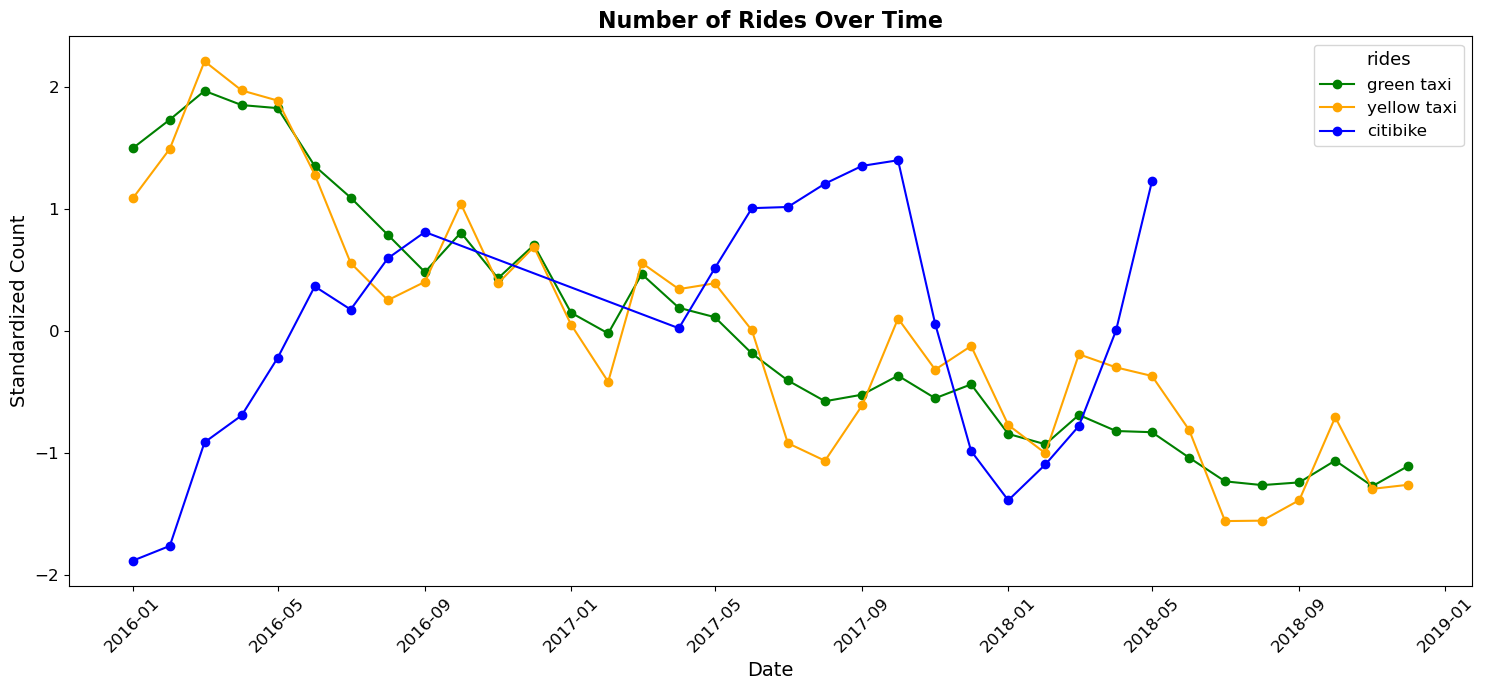

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
label_color = {"green taxi":"green","yellow taxi":"orange","citibike":"blue"}

### ChatGPT for the how to change the color to self-defined
for label in standardized_concat_df['label'].unique():
    df = standardized_concat_df[standardized_concat_df['label'] == label]
    plt.plot(df['month_year'], df['standardized_count'], marker='o', label=label, color = label_color[label])

plt.title('Number of Rides Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Standardized Count', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.ticklabel_format(style='plain', axis='y')

plt.legend(title='rides', fontsize=12, title_fontsize='13')

plt.tight_layout()
plt.show()

A1:

We see that between 2016 and 2018, the popularity of both the green taxis and the yellow taxis was on the decline. This is consistent with our expectations. The proliferation of on-demand, ride hailing services such as Uber and Lyft had already begun shifting consumer preferences since the early 2010’s (Slate). This trend is one that continued through our chosen years of analysis and one that we can clearly observe in the data.

## Q2: How do the usage patterns change for yellow taxi, green taxi, and Citi bike throughout the day?

In [48]:
green_rides_by_hour_df = df_green.where(F.col('year').isin([2016, 2017, 2018]))\
                  .groupBy('hour') \
                  .count() \
                  .orderBy('hour', ascending=True) \
                  .toPandas()

In [49]:
yellow_rides_by_hour_df = df_yellow.where(F.col('year').isin([2016, 2017, 2018]))\
                  .groupBy('hour') \
                  .count() \
                  .orderBy('hour', ascending=True) \
                  .toPandas()

In [50]:
citibike_rides_by_hour_df = df_citibike.where(F.col('year').isin([2016, 2017, 2018]))\
                  .groupBy('hour') \
                  .count() \
                  .orderBy('hour', ascending=True) \
                  .toPandas()

In [51]:
green_rides_by_hour_df['label'] = 'green taxi'
yellow_rides_by_hour_df['label'] = 'yellow taxi'
citibike_rides_by_hour_df['label'] = 'citibike'

In [52]:
import scipy
from scipy import stats

green_rides_by_hour_df['standardized_count'] = stats.zscore(green_rides_by_hour_df['count'])
yellow_rides_by_hour_df['standardized_count'] = stats.zscore(yellow_rides_by_hour_df['count'])
citibike_rides_by_hour_df['standardized_count'] = stats.zscore(citibike_rides_by_hour_df['count'])

In [53]:
concat_hour_df = pd.concat([green_rides_by_hour_df, yellow_rides_by_hour_df, citibike_rides_by_hour_df], axis=0)

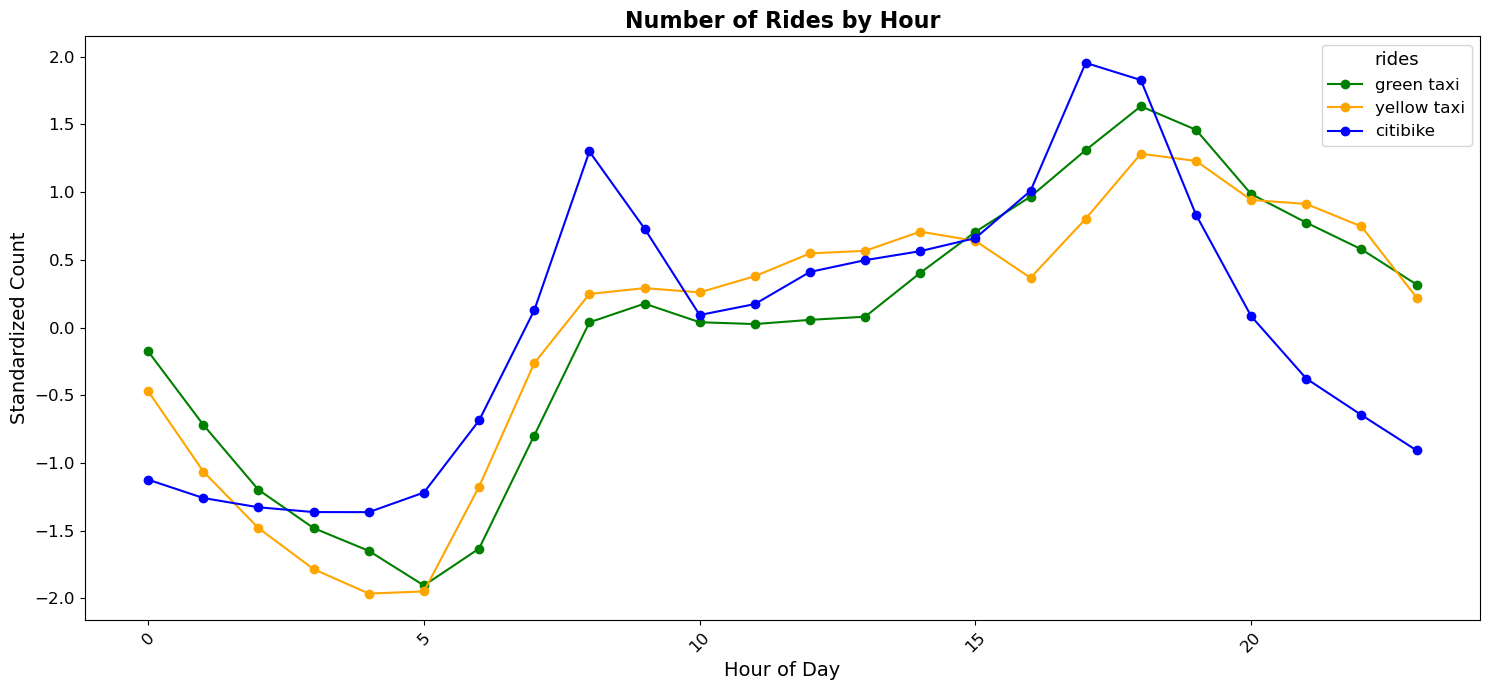

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
label_color = {"green taxi":"green","yellow taxi":"orange","citibike":"blue"}

### ChatGPT for the how to change the color to self-defined
for label in concat_hour_df['label'].unique():
    df = concat_hour_df[concat_hour_df['label'] == label]
    plt.plot(df['hour'], df['standardized_count'], marker='o', label=label, color = label_color[label])

plt.title('Number of Rides by Hour', fontsize=16, fontweight='bold')
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Standardized Count', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.ticklabel_format(style='plain', axis='y')

plt.legend(title='rides', fontsize=12, title_fontsize='13')

plt.tight_layout()
plt.show()

A2: 

We can observe that three types of vehicles all appear to have a significant peak around 6pm, which is likely the evening when people are leaving work. The Citi Bike shows a slightly different pattern with an additional peak around 8am, indicating that biking is also common in the morning. After 6pm, Citi Bike usage declines sharply and remains low until 5am, suggesting very low usage during the late night to early morning hours, likely due to safety concerns or reduced demand. While taxi rides also decrease during these hours, the drop is not as sharp as Citi Bike usage and the usage remains high before 12am, suggesting that taxis are still a preferred type of transportation before midnight, possibly due to their perceived security and privacy at night.

## Q3: How do fare amounts vary for yellow and green taxis throughout different hours of the day?

In [55]:
green_fee_by_hour_df = df_green.where(F.col('total_amount').isNotNull()).where(F.col('total_amount') != 0) \
                  .groupBy('hour') \
                  .agg(F.avg('total_amount').alias('Average fee')) \
                  .orderBy('hour', ascending=True) \
                  .toPandas()

In [56]:
yellow_fee_by_hour_df = df_yellow.where(F.col('total_amount').isNotNull()).where(F.col('total_amount') != 0) \
                  .groupBy('hour') \
                  .agg(F.avg('total_amount').alias('Average fee')) \
                  .orderBy('hour', ascending=True) \
                  .toPandas()

In [57]:
green_fee_by_hour_df['label'] = 'green taxi'
yellow_fee_by_hour_df['label'] = 'yellow taxi'

In [58]:
concat_fee_df = pd.concat([green_fee_by_hour_df, yellow_fee_by_hour_df], axis=0)

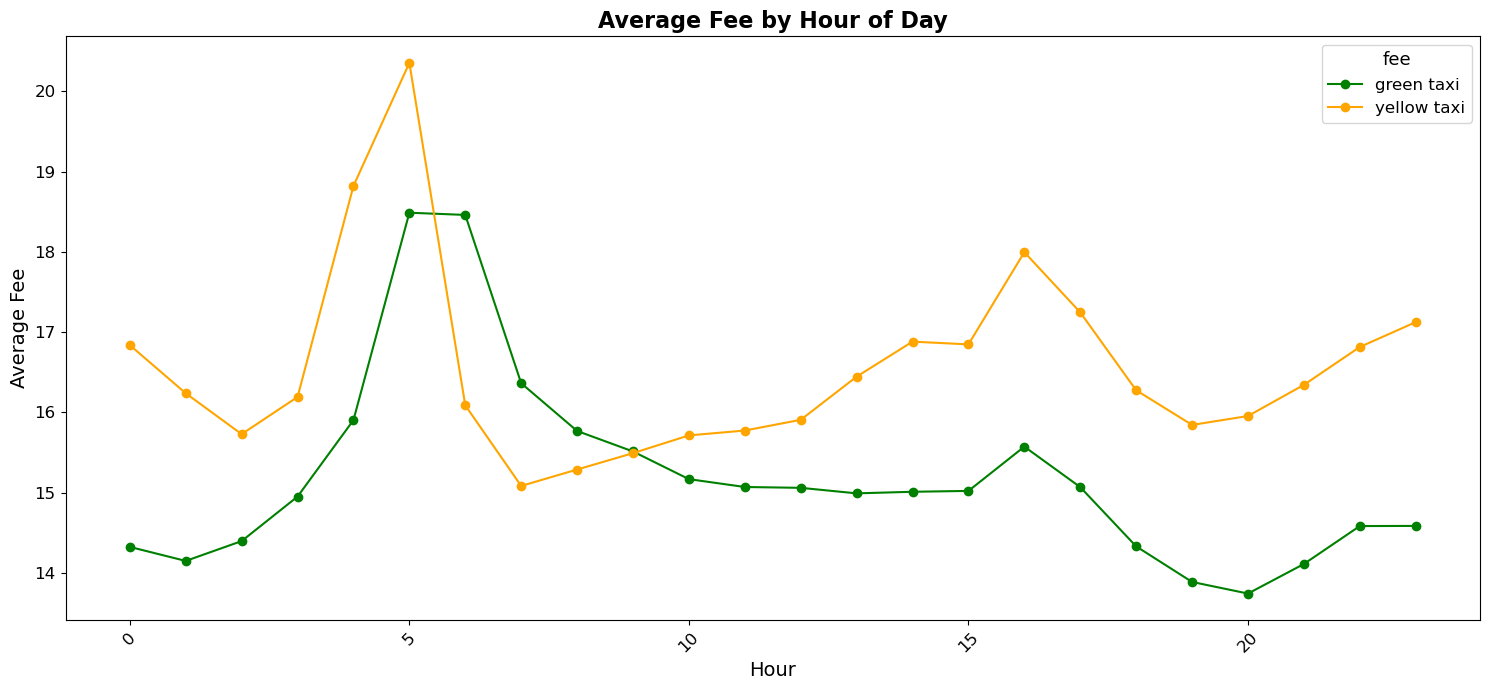

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
label_color = {"green taxi":"green","yellow taxi":"orange"}

### ChatGPT for the how to change the color to self-defined
for label in concat_fee_df['label'].unique():
    df = concat_fee_df[concat_fee_df['label'] == label]
    plt.plot(df['hour'], df['Average fee'], marker='o', label=label , color=label_color[label])

plt.title('Average Fee by Hour of Day', fontsize=16, fontweight='bold')
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Average Fee', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.ticklabel_format(style='plain', axis='y')

plt.legend(title='fee', fontsize=12, title_fontsize='13')

plt.tight_layout()
plt.show()

A3:

The spikes in fare amounts correspond to the information presented in the prior chart, which signaled demand throughout different hours of the day. We can see that both yellow and green taxis follow similar trends in that they both have spikes around commute times.

What is interesting about average fares compared to the average rides per hour is that there is a greater spike in the mornings compared to in the evenings, suggesting that supply for taxis is much higher in the evenings. Also, yellow taxis tend to be more expensive than green taxis throughout the day. This lines up with our understanding of the relative markets served by green and yellow taxis in New York.    

## Q4: What are the popular months for park events? And what times of the day are most events organized?

In [60]:
from pyspark.sql.functions import month

events = events.withColumn("month", month("date"))

In [61]:
events_month_df = events.groupBy('month').count().orderBy('month', ascending=True).toPandas()

In [62]:
from pyspark.sql.functions import hour

events = events.withColumn("hour", hour("start_datetime"))

In [63]:
events_by_hour_df = events.groupBy('hour').count().orderBy('hour', ascending=True).toPandas()

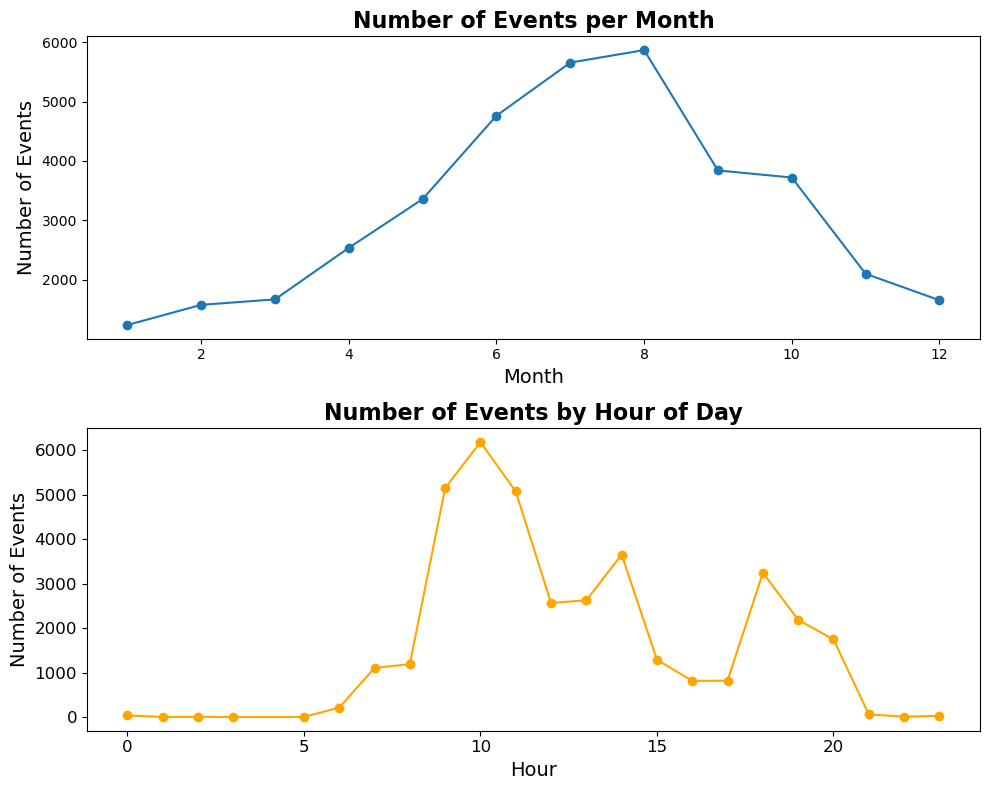

<Figure size 640x480 with 0 Axes>

In [64]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8)) 

### ChatGPT
# Month:
axs[0].plot(events_month_df['month'], events_month_df['count'], label='Number of Events per Month', marker='o')
axs[0].set_title('Number of Events per Month', fontsize=16, fontweight='bold')
axs[0].set_xlabel('Month', fontsize=14)
axs[0].set_ylabel('Number of Events', fontsize=14)
axs[0].tick_params(axis='x')
axs[0].tick_params(axis='y')

# Hour
axs[1].plot(events_by_hour_df['hour'], events_by_hour_df['count'], label='Number of Events by Hour of Day',color='orange', marker='o')
axs[1].set_title('Number of Events by Hour of Day', fontsize=16, fontweight='bold')
axs[1].set_xlabel('Hour', fontsize=14)
axs[1].set_ylabel('Number of Events', fontsize=14)
axs[1].tick_params(axis='x', labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()

A4:

As we analyze the data from 2016 - 2018, we can observe that the number of park events organized increases from the months of May through August and declines after. This could be due to the favorable weather conditions for outdoor events during the summer and early fall months. From the overall data, the number of events organized gradually increases as the weather gets warmer. 

From the hourly trends, we can observe that the most popular start time for park events is before noon, gradually increasing from 8am and reaching the peak at 10am. After 11am, we see a decline in the number of events. We assume this trend is due to people’s preference of spending some refreshing time at the park to start off their days. We also observed spikes in start times around 2pm and 6pm to 8pm. This is probably because people might go to the park around lunchtime to take a break from their work days and they have more leisure time in the evening after work to relax after a busy day.

## Q5: What are the trends of snowfall and precipitation throughout the years 2016-2018, and is there any relationship between the two?

In [65]:
pandas_df = weather_filtered.toPandas()

df_2016 = weather_2016.toPandas()
df_2017 = weather_2017.toPandas()
df_2018 = weather_2018.toPandas()

In [66]:
pandas_df['DATE'] = pd.to_datetime(pandas_df['DATE'])

pandas_df['YEAR'] = pandas_df['DATE'].dt.year
pandas_df['MONTH'] = pandas_df['DATE'].dt.month

monthly_precip = pandas_df.groupby(['YEAR', 'MONTH'])['PRCP'].sum().reset_index()

monthly_precip['MONTH_YEAR'] = pd.to_datetime(monthly_precip[['YEAR', 'MONTH']].assign(DAY=1))

monthly_snow = pandas_df.groupby(['YEAR', 'MONTH'])['SNOW'].sum().reset_index()

monthly_snow['MONTH_YEAR'] = pd.to_datetime(monthly_precip[['YEAR', 'MONTH']].assign(DAY=1))

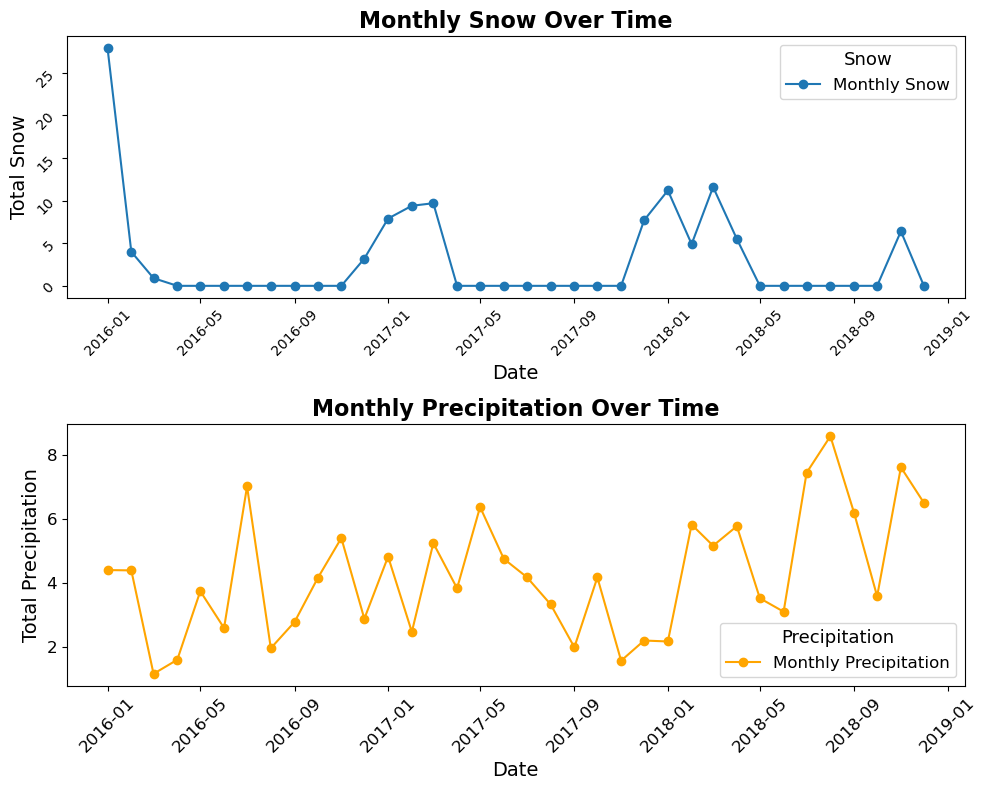

<Figure size 640x480 with 0 Axes>

In [67]:
fig, axs = plt.subplots(2, 1, figsize=(10,8)) 

### ChatGPT
# Snow:
axs[0].plot(monthly_snow['MONTH_YEAR'], monthly_snow['SNOW'], label='Monthly Snow', marker='o')
axs[0].set_title('Monthly Snow Over Time', fontsize=16, fontweight='bold')
axs[0].set_xlabel('Date', fontsize=14)
axs[0].set_ylabel('Total Snow', fontsize=14)
axs[0].tick_params(axis='x', rotation=45)
axs[0].tick_params(axis='y', rotation=45)
axs[0].legend(title='Snow', fontsize=12, title_fontsize='13')

# Precipitation Plot
axs[1].plot(monthly_precip['MONTH_YEAR'], monthly_precip['PRCP'], label='Monthly Precipitation',color='orange', marker='o')
axs[1].set_title('Monthly Precipitation Over Time', fontsize=16, fontweight='bold')
axs[1].set_xlabel('Date', fontsize=14)
axs[1].set_ylabel('Total Precipitation', fontsize=14)
axs[1].tick_params(axis='x', rotation=45, labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)
axs[1].legend(title='Precipitation', fontsize=12, title_fontsize='13')

plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()

A5:

The graph indicates that snowfall in New York City is concentrated from December to March, corresponding to the winter months. The precipitation graph shows higher variability and less obvious seasonality, suggesting that precipitation in this region may be influenced by other factors such as natural events rather than seasonal changes. Furthermore, the graph demonstrates that snowfall does not necessarily correlate with rainfall, implying that high precipitation does not always result in significant snowfall.

# Future Steps

• Identify transportation trends by inspeacting demand patterns influenced by weather conditions, thereby aiding in the understanding and management of supply-and-demand dynamics.

• Investigate the correlation between weather conditions and fare prices, proposing strategies to enhance customer experience while optimizing operational efficiency for service providers. 

• Analyze impact of park events and subsequent street closures on transportation metrics, including transportation mode, fare prices, and ride volume.

# Reference

1. After we come up with our original ideas, we write them down and use chatGPT to help us refine the wordings and sentences.
2. We utilized ChatGPT for assistance when encountering difficulties with generating the plot. Additionally, we indicated the source of the code from ChatGPT by adding a hashtag at the respective location.

# Olivia

## Q1: What is the age distribution of Citibike users?

In [24]:
#Q1: What is the age distribution of Citibike users?
from pyspark.sql.functions import expr, col, count, desc, year, when, sum
from pyspark.sql.window import Window

# make sure there's no null value in the selected column
df_birth = df_trips.where(year("starttime").isNotNull()).where(col("birth_year").isNotNull()) 
df_birth = df_birth.select(year("starttime").alias("year") , "birth_year")
df_birth = df_birth.withColumn("Gen", 
                                when(col("birth_year") <= 1959, "Boomer")
                               .when((col("birth_year") >= 1960) & (col("birth_year") <= 1979), "Gen_X")
                               .when((col("birth_year") >= 1980) & (col("birth_year") <= 1994), "Gen_Y")
                               .when(col("birth_year") >= 1995, "Gen_Z"))
df_birth = df_birth.groupBy("year","Gen").agg(count(col("Gen"))).orderBy("year","Gen")

total_count_by_year = sum(col("count(Gen)")).over(Window.partitionBy("year"))
df_birth = df_birth.withColumn("percentage", (col("count(Gen)") / total_count_by_year) * 100).toPandas()

df_birth = df_birth.set_index('year')
df_birth

,Gen,count(Gen),percentage
year,,,
2016,Boomer,764518,8.514223
2016,Gen_X,3495998,38.933953
2016,Gen_Y,4546001,50.627543
2016,Gen_Z,172787,1.924281
2017,Boomer,914961,7.261838
2017,Gen_X,4480935,35.564164
2017,Gen_Y,6744415,53.528892
2017,Gen_Z,459268,3.645106
2018,Boomer,400652,7.064886


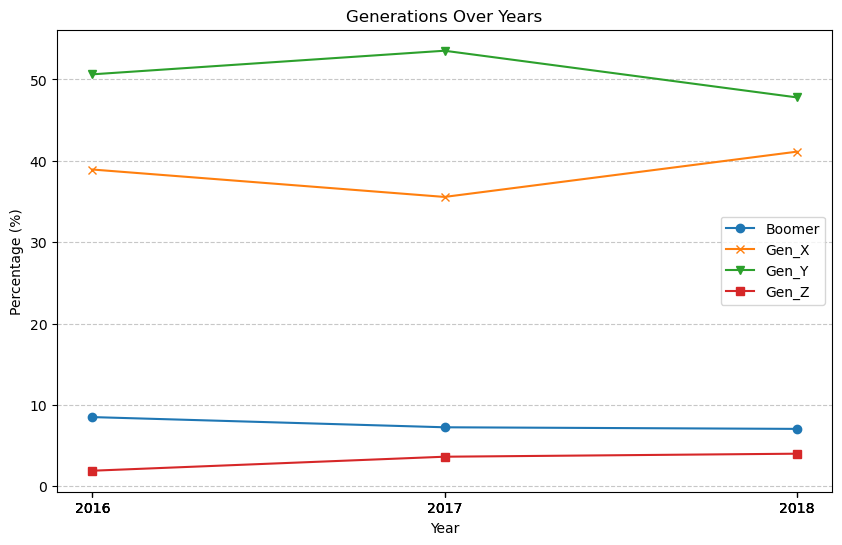

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

boomer = df_birth[df_birth['Gen'] == 'Boomer']
plt.plot(boomer.index, boomer["percentage"], label="Boomer",marker="o")

x = df_birth[df_birth['Gen'] == 'Gen_X']
plt.plot(x.index, x["percentage"], label="Gen_X",marker = "x")

y = df_birth[df_birth['Gen'] == 'Gen_Y']
plt.plot(y.index, y["percentage"], label="Gen_Y",marker = "v")

z = df_birth[df_birth['Gen'] == 'Gen_Z']
plt.plot(z.index, z["percentage"], label="Gen_Z",marker = "s")

plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.title('Generations Over Years')
plt.xticks(df_birth.index, df_birth.index) 
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

A1: We transformed the age dataset into age buckets such as 'Boomer' for those born before 1959, 'Gen_X' for those born between 1960 and 1979, 'Gen_Y' for those born between 1980 and 1994, and 'Gen_Z' for those born after 1995. According to the line plot, it depicts the age distribution of customers using Citibike from 2016 to 2018. Observing over the years, Gen_Y consistently emerges as the group that uses Citibike the most, while Gen_Z consistently represents the group that uses it the least. This may be attributed to their differing lifestyles and preferences. Gen_Y, for example, may exhibit a higher prefernce for using bike-sharing services due to factors such as environmental consciousness, and a desire for cost-effective transportation options. As for Gen_Z might lean towards ridesharing services like Uber, personal electric scooters, or other emerging modes of urban mobility. By understanding these age trends the citibke providers can better tailor their services to meet the evolving needs of different generations.

## Q2: What is the gender distribution of Citibike users?

In [26]:
# Q2: What is the gender distribution of Citibike users?
from pyspark.sql.functions import sum
from pyspark.sql.window import Window

df_gender = df_trips.where(year("starttime").isNotNull()).where(col("tripduration").isNotNull()).where((col("gender") == "female") | (col("gender") == "male")) 
df_gender = df_gender.select(year("starttime").alias("year") ,"gender" , "tripduration")
df_gender = df_gender.groupBy("year","gender").agg(sum(col("tripduration")).alias("total_tripduration")).orderBy("year","gender")                                                                                                             

total_tripduration_by_year = sum(col("total_tripduration")).over(Window.partitionBy("year"))
df_gender = df_gender.withColumn("percentage", (col("total_tripduration") / total_tripduration_by_year) * 100).toPandas()

df_gender = df_gender.set_index('year')
df_gender

,gender,total_tripduration,percentage
year,,,
2016,female,2063673796,27.660492
2016,male,5397053292,72.339508
2017,female,3342082773,28.983502
2017,male,8188900363,71.016498
2018,female,1267776263,28.046636
2018,male,3252467350,71.953364


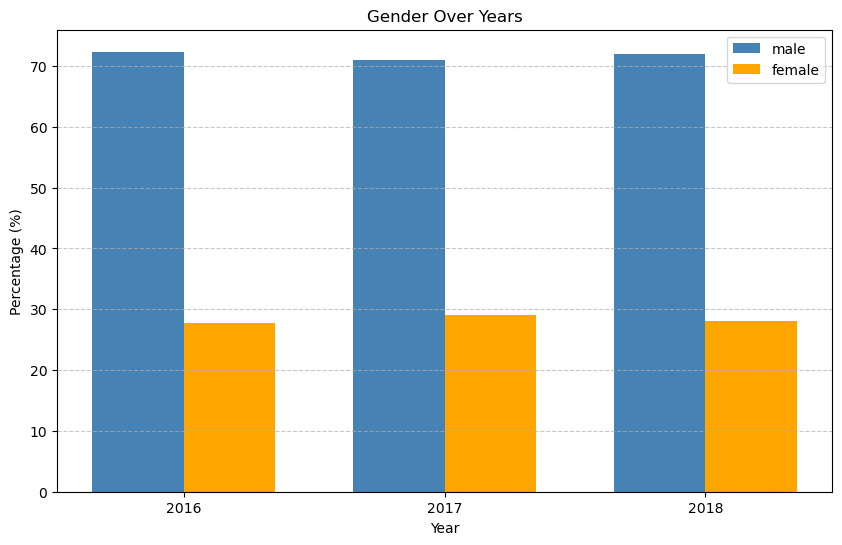

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

male = df_gender[df_gender['gender'] == 'male']
female = df_gender[df_gender['gender'] == 'female']


plt.bar(male.index - 0.35/2, male["percentage"], width = 0.35, label="male", color="steelblue")
plt.bar(female.index + 0.35/2, female["percentage"], width = 0.35, label="female", color="orange")

plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.title('Gender Over Years')
plt.xticks(male.index, male.index) 
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7) # ChatGPT
plt.show()


A2: The bar plot indicate the gender distribution among Citibike users spanning from 2016 to 2018. It consistently show a higher usage count among males compared to females, with males often exceeding female usage by more than 2.5 times. One potential explanation is that men generally exhibit a higher inclination towards cycling, possibly due to factors like perceived convenience, speed, or preference for active modes of transportation. Conversely, females might tend to use alternative transportation options such as cars or public transit, influenced by safety concerns or societal norms.

## Q3: What is the percentage distribution of total trip duration by user type?

In [9]:
# Q3: Duration time vs. subscription 
from pyspark.sql.functions import col, sum

df_sub_time = df_trips.where(col("usertype").isNotNull()).where(col("tripduration").isNotNull()) \
                      .select("usertype","tripduration") \
                      .groupBy("usertype").agg(sum(col("tripduration")).alias("total_tripduration"))

# total_duration = df_sub_time.select(sum(col("total_tripduration"))).collect()[0][0]
# df_sub_time = df_sub_time.withColumn("percentage", (col("total_tripduration") / total_duration) * 100).toPandas()
df_sub_time.toPandas()

,usertype,total_tripduration
0,Subscriber,21763270679
1,Customer,8382839849


In [10]:
from pyspark.sql.functions import col, count
from pyspark.sql.functions import monotonically_increasing_id, avg

df_sub_count = df_trips.where(col("usertype").isNotNull()) \
                       .select(monotonically_increasing_id().alias('id'),"usertype") \
                       .groupBy("usertype").agg(count(col("id")).alias("count"))
df_sub_count = df_sub_count.withColumnRenamed("usertype","ussertype")
df_sub_count.toPandas()

,ussertype,count
0,Subscriber,26632968
1,Customer,3419383


In [11]:
df_sub = df_sub_time.join(df_sub_count , df_sub_time["usertype"]==df_sub_count["ussertype"]) \
                    .drop("ussertype") \
                    .toPandas()

df_sub["avg_tripduration"] = df_sub["total_tripduration"] / df_sub["count"] * 100
df_sub["percentage (%)"] = (df_sub["avg_tripduration"] / df_sub["avg_tripduration"].sum()) * 100
df_sub

,usertype,total_tripduration,count,avg_tripduration,percentage (%)
0,Subscriber,21763270679,26632968,81715.528960,24.999241
1,Customer,8382839849,3419383,245156.504814,75.000759


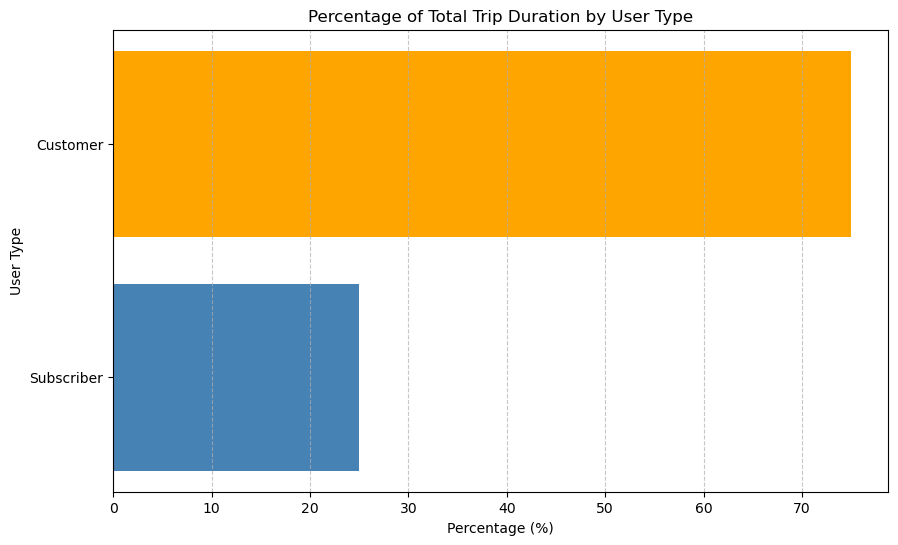

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(df_sub["usertype"], df_sub["percentage (%)"] ,color=['steelblue', 'orange'])

plt.xlabel('Percentage (%)')
plt.ylabel('User Type')
plt.title('Percentage of Total Trip Duration by User Type')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

A3: The bar plot displays the percentage distribution of total trip duration by user type. It illustrates that individuals without monthly plans use citibike more frequently than those with monthly plans, suggesting a disparity between subscribers and customers. I believe this discrepancy arises because customers have greater flexibility in their citibike usage. Subscribers with monthly plans are likely to utilize citibike for regular, short-distance commutes or errands, resulting in shorter trip durations but higher usage frequency.

## Q4: What is the distribution of usage volume between weekends and weekdays?

In [13]:
# Q4-1: weekend / weekday usage volumn
# easy version
from pyspark.sql.functions import date_format, col, when, monotonically_increasing_id, count, sum, lit

df_trips = df_trips.withColumn('day/end', date_format('starttime', 'EEEE')) \
                   .withColumn("week end/day",
                              when(col("day/end").isin("Monday", "Tuesday", "Wednesday", "Thursday", "Friday"), "weekday")
                              .when(col("day/end").isin("Saturday","Sunday"), "weekend") 
                              ) \
                   .withColumn("id",monotonically_increasing_id())

end_day_count = df_trips.select("id", "week end/day") \
                        .groupBy("week end/day") \
                        .agg(count("id").alias("usage volumn"))

weekday_avg_usage = end_day_count.where(col('week end/day') == 'weekday').select('usage volumn').first()[0] / 5
weekend_avg_usage = end_day_count.where(col('week end/day') == 'weekend').select('usage volumn').first()[0] / 2

end_day_count = end_day_count.withColumn("avg_usage", 
                                          when(col('week end/day') == 'weekday', lit(weekday_avg_usage))
                                         .when(col('week end/day') == 'weekend', lit(weekend_avg_usage)))

total_count = end_day_count.select(sum("avg_usage")).collect()[0][0]
end_day_count = end_day_count.withColumn("percentage", (col("avg_usage") / total_count) * 100).toPandas()
end_day_count

,week end/day,usage volumn,avg_usage,percentage
0,weekday,22859868,4571973.6,55.972738
1,weekend,7192483,3596241.5,44.027262


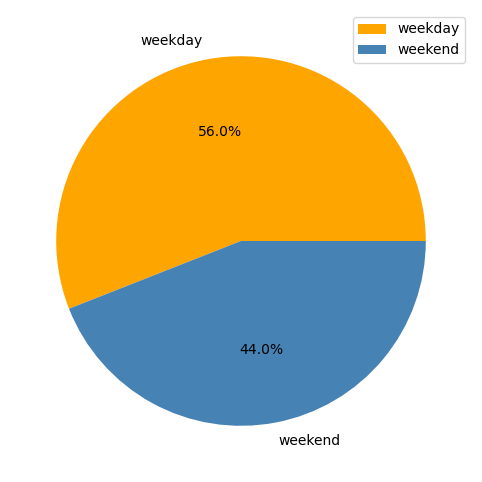

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

color = ["orange", "steelblue"]                                                        # ChatGpt: I ask chatgpt how to show the statistic on the plot
plt.pie(end_day_count["percentage"], labels=end_day_count["week end/day"], colors=color, autopct='%1.1f%%')

plt.legend(loc='best')
plt.legend()
plt.grid()
plt.show()

In [15]:
# Q4-2: weekend / weekday usage volumn
# hard version
from pyspark.sql.functions import hour, monotonically_increasing_id, count

weekend_day_commute = df_trips.select(monotonically_increasing_id().alias('id'),"week end/day",hour("starttime").alias("start hour")) \
                              .groupBy("week end/day", "start hour") \
                              .agg(count(col("id")).alias("usage volume")).orderBy("week end/day","start hour").toPandas()

weekend_day_commute.head()

,week end/day,start hour,usage volume
0,weekday,0,156620
1,weekday,1,73897
2,weekday,2,38709
3,weekday,3,23170
4,weekday,4,32920


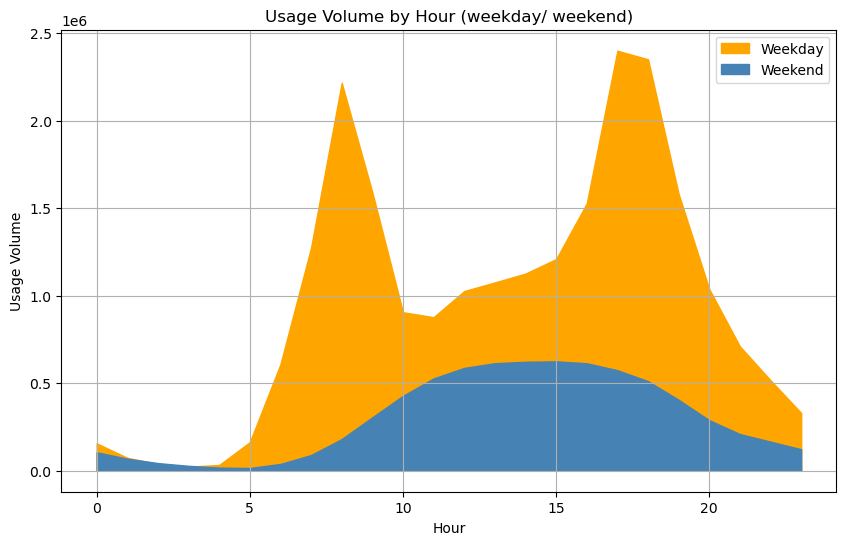

In [17]:
plt.figure(figsize=(10, 6))

weekday_day = weekend_day_commute[weekend_day_commute['week end/day'] == 'weekday']
weekend_end = weekend_day_commute[weekend_day_commute['week end/day'] == 'weekend']

    # CHatGPT: .fill_between function is the one I ask GhatGPT
    # used to fill the area between two horizontal curves
plt.fill_between(weekday_day['start hour'], weekday_day['usage volume'], color='orange', label='Weekday')
plt.fill_between(weekend_end['start hour'], weekend_end['usage volume'], color='steelblue', label='Weekend')

plt.xlabel('Hour')
plt.ylabel('Usage Volume')
plt.title('Usage Volume by Hour (weekday/ weekend)')
plt.legend()
plt.grid()
plt.show()

A4: We transformed the usage information into buckets, classifying Monday to Friday as Weekdays and Saturday and Sunday as Weekends. The area plot indicates that most of the usage occurs on weekdays, likely due to commuting or running errands, while weekends are primarily used for leisure activities or shorter travel distances. Additionally, both weekends and weekdays show increased usage during commuting hours, with peaks observed in the morning from 7 am to 9 am and in the afternoon from 4 pm to 7 pm.

## Q5: What are the top 10 and bottom 10 start and end stations based on usage volume?

In [33]:
# Q5-1: top 10 start_station usage map
from pyspark.sql.functions import monotonically_increasing_id, avg
start_station = df_trips.select("id", "start_station_name", "start_station_latitude", "start_station_longitude")
start_station = start_station.groupBy("start_station_name") \
                         .agg(count("id").alias("usage volumn"), 
                              avg("start_station_latitude").alias("start_lat"), 
                              avg("start_station_longitude").alias("start_long")) \
                         .orderBy("usage volumn") \
                         .toPandas()
start_station

,start_station_name,usage volumn,start_lat,start_long
0,2 Ave & E 105 St,1,40.789818,-73.942963
1,333 Johnson TEST 1,1,0.000000,0.000000
2,LPI Facility,2,0.000000,0.000000
3,Expansion Tech Station,2,40.669804,-73.994904
4,Washington Square E,2,40.730495,-73.995720
...,...,...,...,...
881,West St & Chambers St,201557,40.717548,-74.013222
882,Broadway & E 22 St,203665,40.740345,-73.989548
883,W 21 St & 6 Ave,204820,40.741741,-73.994156
884,E 17 St & Broadway,207310,40.737049,-73.990089


In [34]:
top10_start = start_station.tail(10)
top10_start

,start_station_name,usage volumn,start_lat,start_long
876,W 41 St & 8 Ave,158196,40.756405,-73.990028
877,W 20 St & 11 Ave,160338,40.746746,-74.007759
878,Broadway & E 14 St,162791,40.734547,-73.990738
879,12 Ave & W 40 St,165308,40.760876,-74.002777
880,8 Ave & W 33 St,169916,40.751553,-73.993935
881,West St & Chambers St,201557,40.717548,-74.013222
882,Broadway & E 22 St,203665,40.740345,-73.989548
883,W 21 St & 6 Ave,204820,40.741741,-73.994156
884,E 17 St & Broadway,207310,40.737049,-73.990089
885,Pershing Square North,303788,40.751873,-73.977707


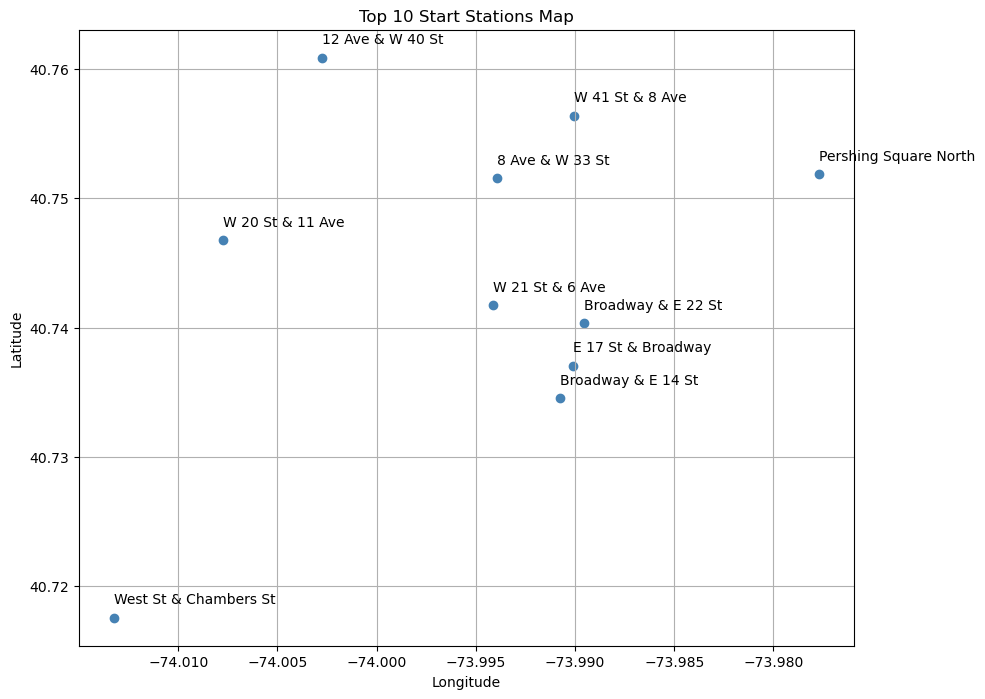

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

start_name = top10_start['start_station_name']
start_long = top10_start['start_long']
start_lat = top10_start['start_lat']

plt.figure(figsize=(10,8))
plt.scatter(start_long, start_lat, color='steelblue') 

# ChatGPT: I ask chatgpt how to add the annotation beside each data points
for index, row in top10_start.iterrows():
    plt.annotate(row['start_station_name'], (row['start_long'], row['start_lat']), textcoords="offset points", xytext=(0,10), ha='left')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Top 10 Start Stations Map')
plt.grid()
plt.show()

In [39]:
# Q5-2: bottom 10 usage start_station map
tail10_start = start_station.head(10)
tail10_start.drop(index=[1,2], inplace=True)
tail10_start

/tmp/ipykernel_11845/1794515300.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tail10_start.drop(index=[1,2], inplace=True)


,start_station_name,usage volumn,start_lat,start_long
0,2 Ave & E 105 St,1,40.789818,-73.942963
3,Expansion Tech Station,2,40.669804,-73.994904
4,Washington Square E,2,40.730495,-73.995720
5,NYCBS Depot - FAR,3,40.751484,-73.996765
6,Apache,3,40.669765,-73.994743
7,NYCBS DEPOT - DELANCEY,6,40.716446,-73.982330
8,NYCBS Depot BAL - DYR,7,40.759029,-73.993858
9,Kiosk in a box Deployment,7,40.708611,-73.928505


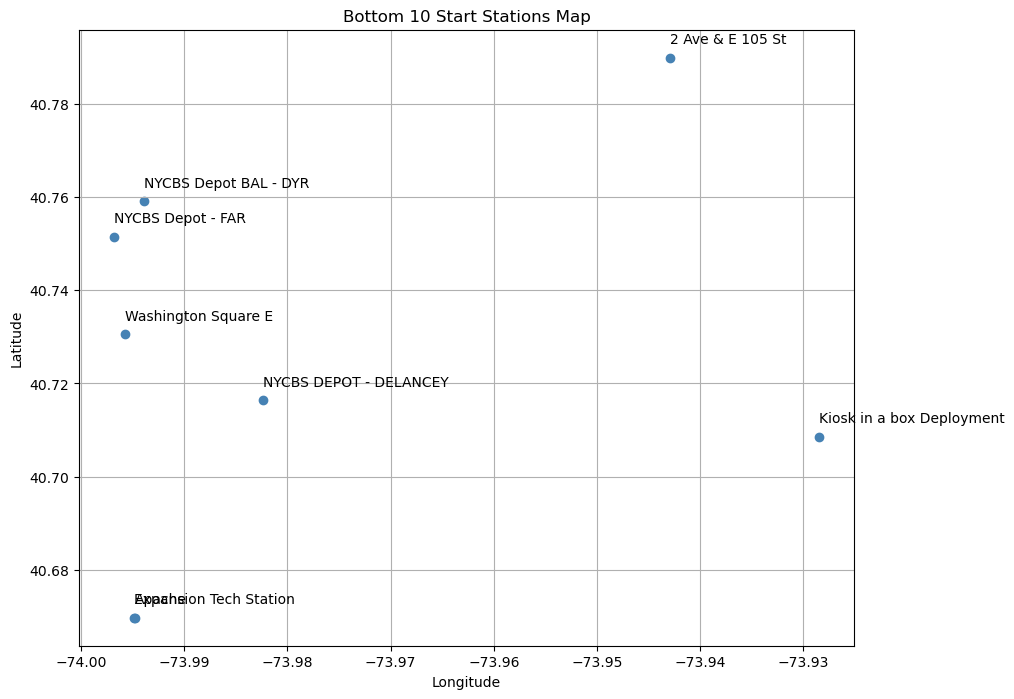

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

start_name = tail10_start['start_station_name']
start_long = tail10_start['start_long']
start_lat = tail10_start['start_lat']

plt.figure(figsize=(10,8))
plt.scatter(start_long, start_lat, color='steelblue') 

# ChatGPT: I ask chatgpt how to add the annotation beside each data points
for index, row in tail10_start.iterrows():
    plt.annotate(row['start_station_name'], (row['start_long'], row['start_lat']), textcoords="offset points", xytext=(0,10), ha='left')


plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Bottom 10 Start Stations Map')
plt.grid()
plt.show()

In [41]:
# Q5-3: top 10 end_station usage map

from pyspark.sql.functions import monotonically_increasing_id, avg
end_station = df_trips.select("id", "end_station_name", "end_station_latitude", "end_station_longitude")
end_station = end_station.groupBy("end_station_name") \
                         .agg(count("id").alias("usage volumn"), 
                              avg("end_station_latitude").alias("end_lat"), 
                              avg("end_station_longitude").alias("end_long")) \
                         .orderBy("usage volumn") \
                         .toPandas()
end_station

,end_station_name,usage volumn,end_lat,end_long
0,Union St,1,40.718212,-74.083641
1,Grand St,1,40.715179,-74.037682
2,Hilltop,1,40.731171,-74.057571
3,JCBS Depot,1,40.709652,-74.068604
4,Monmouth and 6th,1,40.725685,-74.048790
...,...,...,...,...
927,W 21 St & 6 Ave,207056,40.741741,-73.994156
928,West St & Chambers St,213276,40.717548,-74.013222
929,Broadway & E 22 St,213435,40.740345,-73.989548
930,E 17 St & Broadway,214623,40.737049,-73.990089


In [42]:
top10_end = end_station.tail(10)
top10_end

,end_station_name,usage volumn,end_lat,end_long
922,W 41 St & 8 Ave,160814,40.756405,-73.990028
923,Broadway & E 14 St,163817,40.734547,-73.990738
924,8 Ave & W 33 St,165702,40.751553,-73.993935
925,W 20 St & 11 Ave,168973,40.746746,-74.007759
926,12 Ave & W 40 St,171617,40.760876,-74.002777
927,W 21 St & 6 Ave,207056,40.741741,-73.994156
928,West St & Chambers St,213276,40.717548,-74.013222
929,Broadway & E 22 St,213435,40.740345,-73.989548
930,E 17 St & Broadway,214623,40.737049,-73.990089
931,Pershing Square North,298957,40.751873,-73.977707


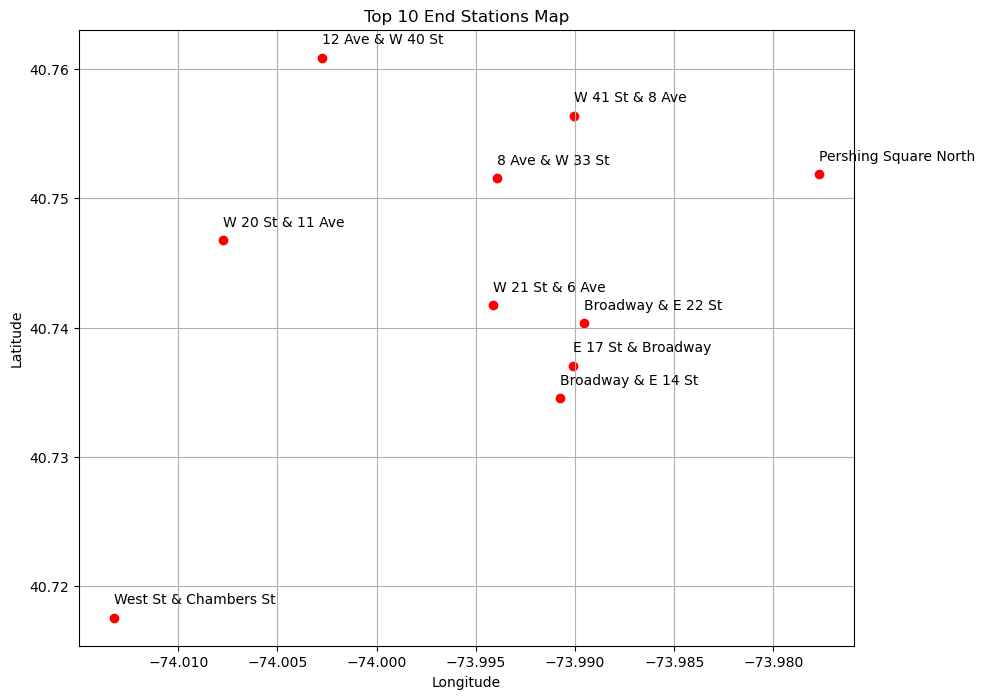

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

start_name = top10_end['end_station_name']
start_long = top10_end['end_long']
start_lat = top10_end['end_lat']

plt.figure(figsize=(10,8))
plt.scatter(start_long, start_lat, color='red') 

# ChatGPT: I ask chatgpt how to add the annotation beside each data points
for index, row in top10_end.iterrows():
    plt.annotate(row['end_station_name'], (row['end_long'], row['end_lat']), textcoords="offset points", xytext=(0,10), ha='left')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Top 10 End Stations Map')
plt.grid()
plt.show()

In [46]:
# Q5-4: bottom 10 usage end_station map
tail10_end = end_station.head(10)
tail10_end.drop(index=[8], inplace=True)
tail10_end

/tmp/ipykernel_11845/1988031665.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tail10_end.drop(index=[8], inplace=True)


,end_station_name,usage volumn,end_lat,end_long
0,Union St,1,40.718212,-74.083641
1,Grand St,1,40.715179,-74.037682
2,Hilltop,1,40.731171,-74.057571
3,JCBS Depot,1,40.709652,-74.068604
4,Monmouth and 6th,1,40.725685,-74.048790
5,Pathmark Depot,1,40.672333,-73.997063
6,Communipaw & Berry Lane,1,40.714359,-74.066612
7,NJCU,1,40.710110,-74.085846
9,NYCBS Depot - GOW Annex,1,40.668884,-73.994812


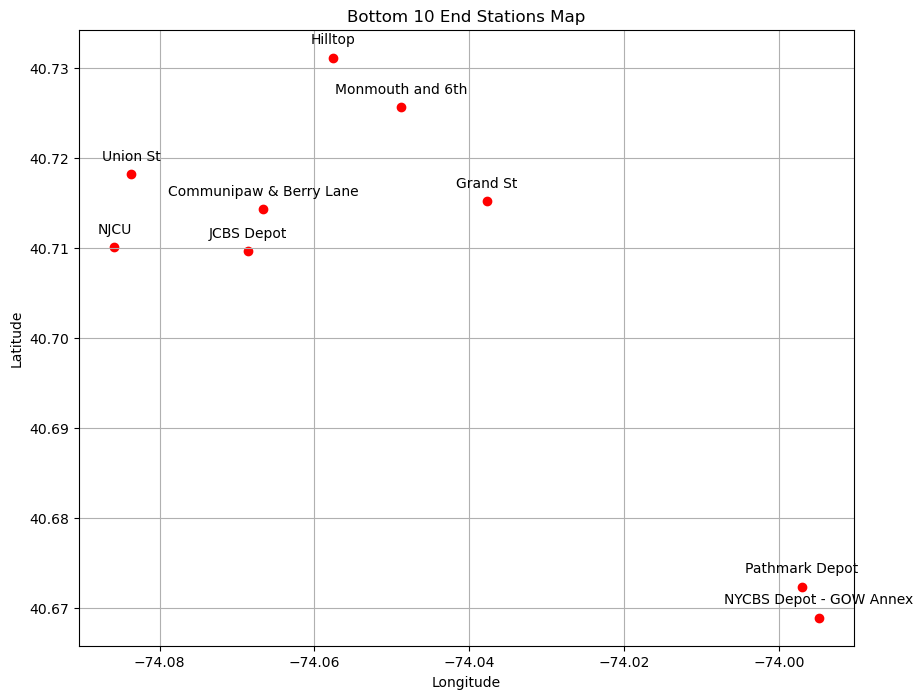

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

start_name = tail10_end['end_station_name']
start_long = tail10_end['end_long']
start_lat = tail10_end['end_lat']

plt.figure(figsize=(10,8))
plt.scatter(start_long, start_lat, color='red') 

# ChatGPT: I ask chatgpt how to add the annotation beside each data points
for index, row in tail10_end.iterrows():
    plt.annotate(row['end_station_name'], (row['end_long'], row['end_lat']), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Bottom 10 End Stations Map')
plt.grid()
plt.show()

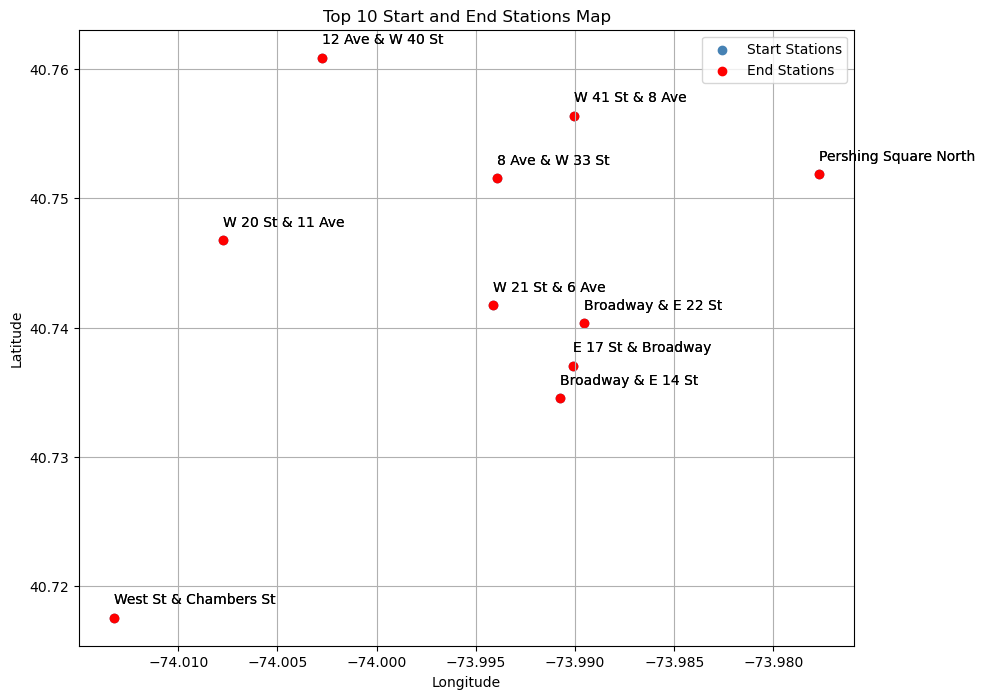

In [48]:
# make the top 10 start and end station together
# the plots have overlapped because they are the same

import pandas as pd
import matplotlib.pyplot as plt

start_name = top10_start['start_station_name']
start_long = top10_start['start_long']
start_lat = top10_start['start_lat']

end_name = top10_end['end_station_name']
end_long = top10_end['end_long']
end_lat = top10_end['end_lat']

plt.figure(figsize=(10,8))

plt.scatter(start_long, start_lat, color='steelblue', label='Start Stations') 
for index, row in top10_start.iterrows():
    plt.annotate(row['start_station_name'], (row['start_long'], row['start_lat']), textcoords="offset points", xytext=(0,10), ha='left')

plt.scatter(end_long, end_lat, color='red', label='End Stations') 
for index, row in top10_end.iterrows():
    plt.annotate(row['end_station_name'], (row['end_long'], row['end_lat']), textcoords="offset points", xytext=(0,10), ha='left')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Top 10 Start and End Stations Map')
plt.legend()
plt.grid()
plt.show()

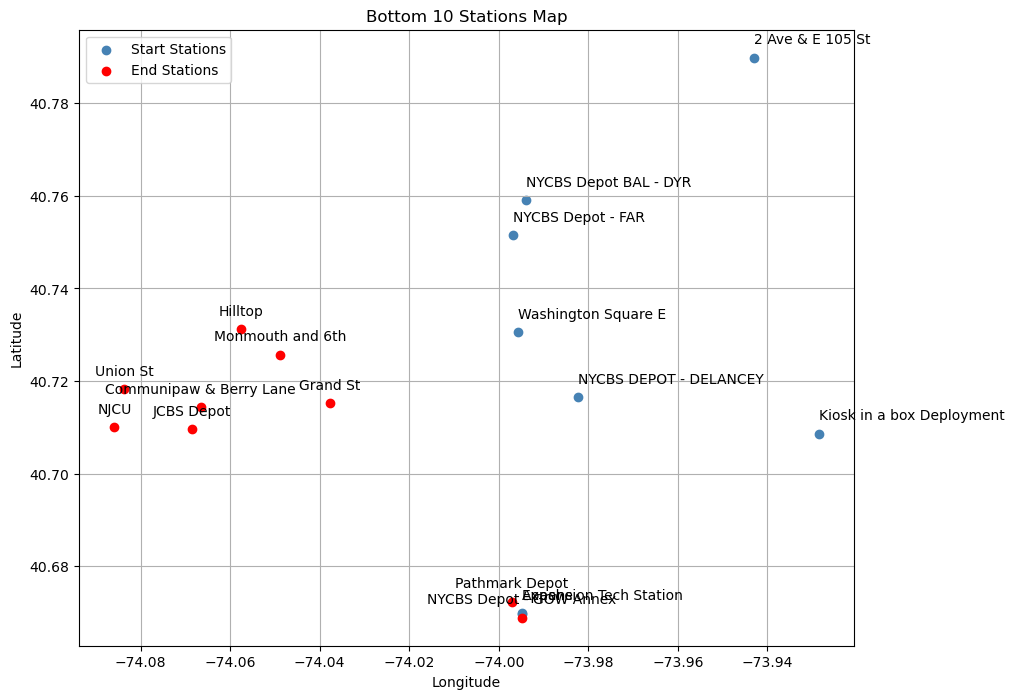

In [49]:
# make the bottom 10 start and end station together

import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt

# Start stations
start_name = tail10_start['start_station_name']
start_long = tail10_start['start_long']
start_lat = tail10_start['start_lat']

plt.figure(figsize=(10,8))
plt.scatter(start_long, start_lat, color='steelblue', label='Start Stations') 

# Add annotations
for index, row in tail10_start.iterrows():
    plt.annotate(row['start_station_name'], (row['start_long'], row['start_lat']), textcoords="offset points", xytext=(0,10), ha='left')

# End stations
end_name = tail10_end['end_station_name']
end_long = tail10_end['end_long']
end_lat = tail10_end['end_lat']

plt.scatter(end_long, end_lat, color='red', label='End Stations') 

# Add annotations
for index, row in tail10_end.iterrows():
    plt.annotate(row['end_station_name'], (row['end_long'], row['end_lat']), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Bottom 10 Stations Map')
plt.legend()
plt.grid()
plt.show()

A5: Utilizing the longitude and latitude of the stations, I plotted them on a map to visualize their respective locations. Observing the top 10 start and end stations, it's evident that all the data points overlap completely. This indicates that the most frequently used start and end stations are identical, including locations such as W 21 St & 6 Ave and Broadway & E 22 St. This alignment with real-world usage patterns makes sense, as the high-traffic areas are typically situated around Broadway or in the midtown and uptown regions of Manhattan. However, the bottom 10 start and end stations differ significantly. They still share some mutual characteristics, with stations located more towards the downtown area of NYC. Understanding these usage patterns can inform resource allocation and infrastructure planning for Citibike in the city.

## Q6: Do weather conditions such as temperature, snowfall, and precipitation affect Citibike usage?

In [50]:
# trip_weather join
trip_weather = df_trips.join(weather,df_trips['date'] == weather['date_weather'],how ='left')
trip_weather = trip_weather.drop("date_weather")
trip_weather.limit(5).toPandas()

24/04/16 20:49:35 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,label,date,day/end,week end/day,id,PRCP,SNOW,SNWD,TMIN,TMAX
0,981,2016-08-17 18:29:16.000,2016-08-17 18:45:37.000,457,Broadway & W 58 St,40.766953,-73.981697,3169,Riverside Dr & W 82 St,40.787209,...,bike,2016-08-17,Wednesday,weekday,0,0.01,0.0,0.0,77,85
1,1172,2018-04-03 09:08:54.171,2018-04-03 09:28:26.766,229,Great Jones St,40.727436,-73.993790,232,Cadman Plaza E & Tillary St,40.695976,...,bike,2018-04-03,Tuesday,weekday,1,0.26,0.0,0.0,39,43
2,130,2018-05-30 12:36:16.083,2018-05-30 12:38:26.542,358,Christopher St & Greenwich St,40.732914,-74.007111,346,Bank St & Hudson St,40.736530,...,bike,2018-05-30,Wednesday,weekday,2,0.00,0.0,0.0,61,78
3,827,2017-11-03 20:23:46.000,2017-11-03 20:37:34.000,2012,E 27 St & 1 Ave,40.739445,-73.976807,383,Greenwich Ave & Charles St,40.735237,...,bike,2017-11-03,Friday,weekday,3,0.00,0.0,0.0,51,74
4,629,2018-03-30 15:56:57.484,2018-03-30 16:07:26.982,394,E 9 St & Avenue C,40.725212,-73.977684,252,MacDougal St & Washington Sq,40.732265,...,bike,2018-03-30,Friday,weekday,4,0.03,0.0,0.0,44,62


In [51]:
## this daily count table can be re-used ##
from pyspark.sql.functions import count, col
from pyspark.sql.functions import monotonically_increasing_id, avg

daily_count = trip_weather.select(monotonically_increasing_id().alias('id'),"date").groupBy("date").agg(count(col("id")).alias("usage volumn")).orderBy("date")
daily_count = daily_count.withColumnRenamed("date","date_daily_count")
daily_count.limit(5).toPandas()

,date_daily_count,usage volumn
0,2016-01-01,11009
1,2016-01-02,14587
2,2016-01-03,15499
3,2016-01-04,19593
4,2016-01-05,18053


In [52]:
# Q6: does the temperature affect the cititbike's usage volumn
temp = trip_weather.select('date','TMIN','TMAX')
temp = temp.groupby("date").agg(avg(col("TMIN")),avg(col("TMAX"))).orderBy("date")

temp_all = temp.join(daily_count,temp['date']== daily_count['date_daily_count'],how ='left')
temp_all = temp_all.drop("date_daily_count").toPandas()
temp_all["avg_temp"] = (temp_all["avg(TMIN)"] + temp_all["avg(TMAX)"]) / 2
temp_all.head()

,date,avg(TMIN),avg(TMAX),usage volumn,avg_temp
0,2017-08-11,69.0,82.0,63140,75.5
1,2017-09-11,55.0,76.0,71917,65.5
2,2016-03-01,39.0,52.0,30509,45.5
3,2018-05-28,56.0,69.0,49043,62.5
4,2016-04-25,50.0,69.0,42308,59.5


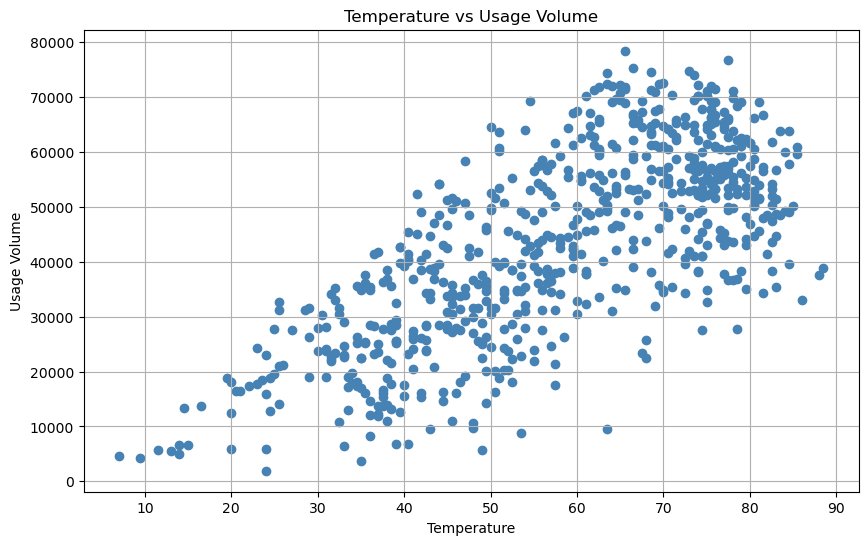

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.scatter(temp_all["avg_temp"], temp_all["usage volumn"], color='steelblue')

plt.xlabel('Temperature')
plt.ylabel('Usage Volume')
plt.title('Temperature vs Usage Volume')
plt.grid()
plt.show()

In [54]:
# Q7: does the snow affect the cititbike's usage volumn
snow = trip_weather.select('date','SNOW')
snow = snow.groupby("date").agg(avg(col("SNOW")).alias("snow")).orderBy("date")

snow_all = snow.join(daily_count,snow['date']== daily_count['date_daily_count'],how ='left')
snow_all = snow_all.drop("date_daily_count").toPandas()
snow_all.head()

,date,snow,usage volumn
0,2017-08-11,0.0,63140
1,2017-09-11,0.0,71917
2,2016-03-01,0.0,30509
3,2018-05-28,0.0,49043
4,2016-04-25,0.0,42308


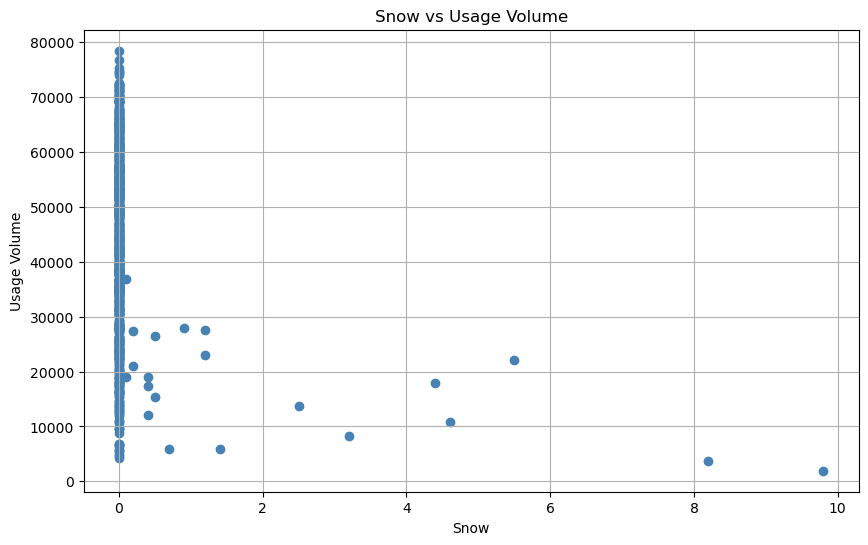

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.scatter(snow_all["snow"], snow_all["usage volumn"], color='steelblue')

plt.xlabel('Snow')
plt.ylabel('Usage Volume')
plt.title('Snow vs Usage Volume')
plt.grid()
plt.show()

In [56]:
# Q8: does the precipitation affect the cititbike's usage volumn
PRCP = trip_weather.select('date','PRCP')
PRCP = PRCP.groupby("date").agg(avg(col("PRCP")).alias("precipitation")).orderBy("date")

PRCP_all = PRCP.join(daily_count,PRCP['date']== daily_count['date_daily_count'],how ='left')
PRCP_all = PRCP_all.drop("date_daily_count").toPandas()
PRCP_all.head()

,date,precipitation,usage volumn
0,2017-09-11,0.0,71917
1,2018-05-28,0.0,49043
2,2017-08-11,0.0,63140
3,2016-03-01,0.0,30509
4,2018-03-17,0.0,27672


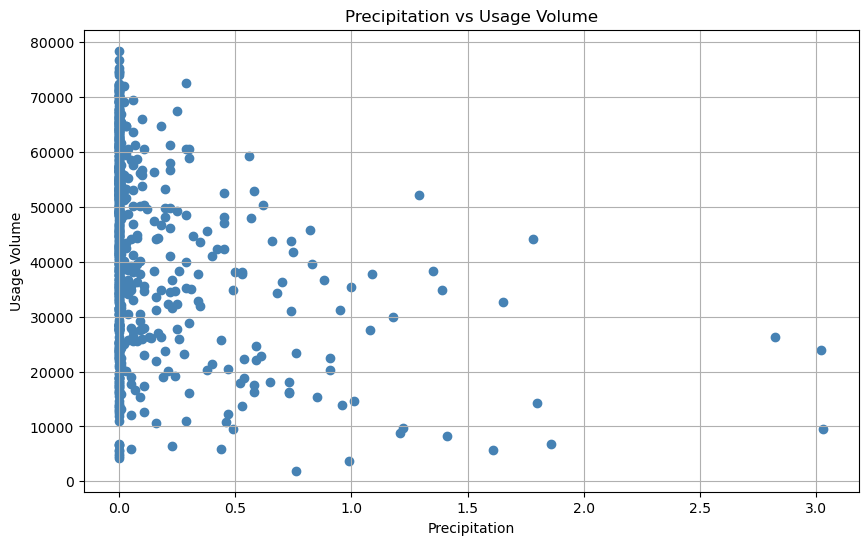

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.scatter(PRCP_all["precipitation"], PRCP_all["usage volumn"], color='steelblue')

plt.xlabel('Precipitation')
plt.ylabel('Usage Volume')
plt.title('Precipitation vs Usage Volume')
plt.grid()
plt.show()

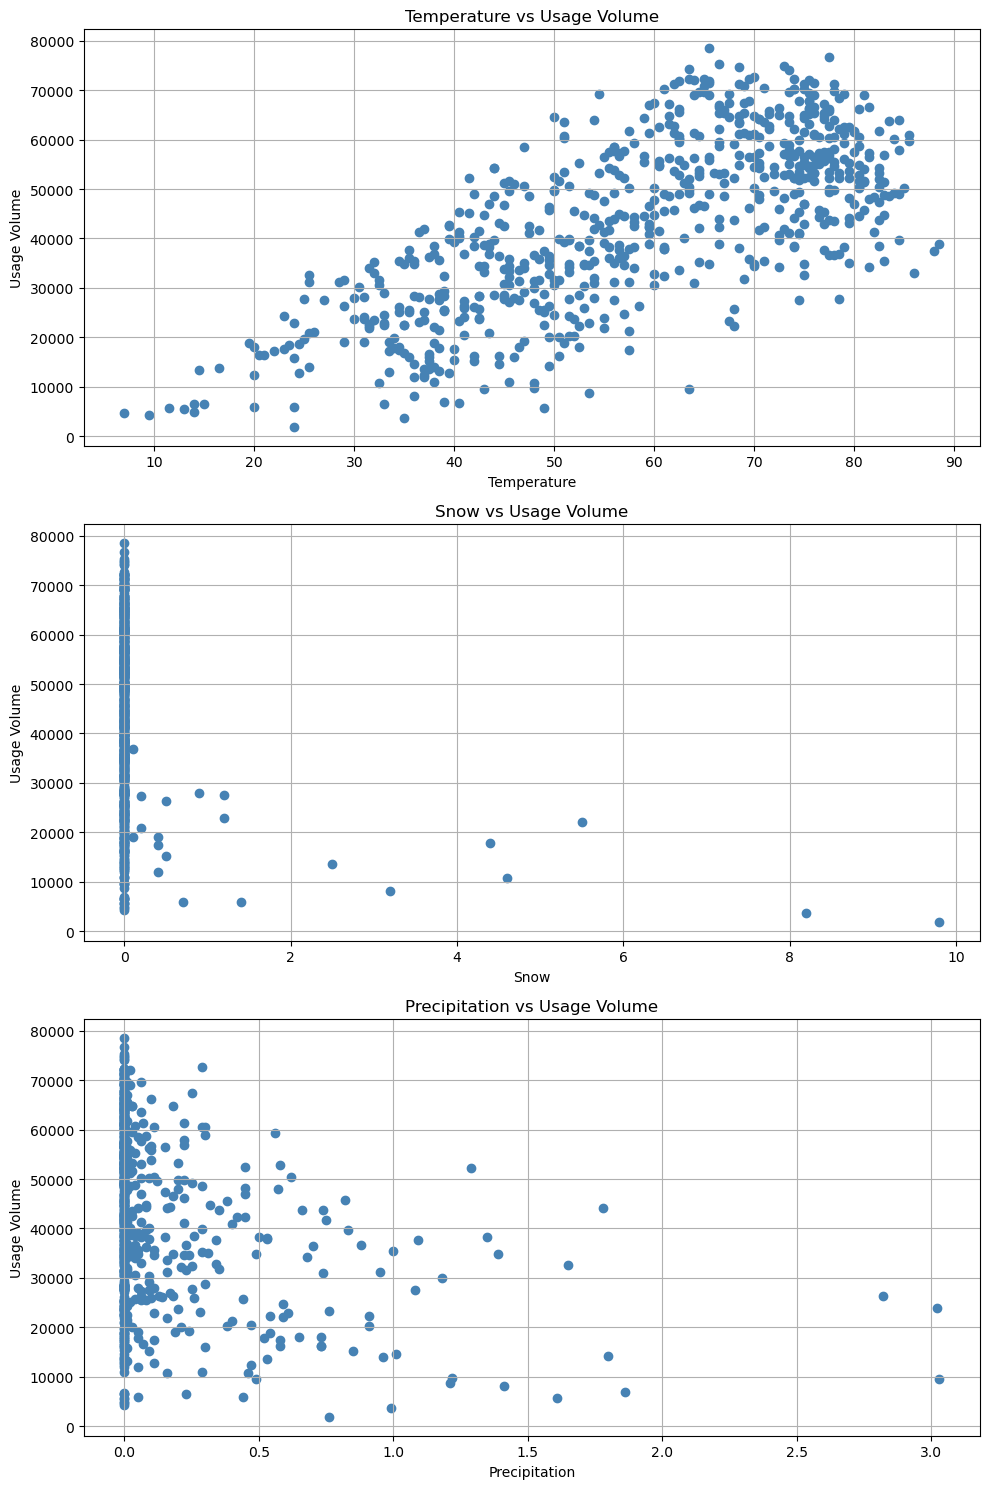

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# temperature / usage volumn
axes[0].scatter(temp_all["avg_temp"], temp_all["usage volumn"], color='steelblue')
axes[0].set_xlabel('Temperature')
axes[0].set_ylabel('Usage Volume')
axes[0].set_title('Temperature vs Usage Volume')
axes[0].grid()

# snow / usage volumn
axes[1].scatter(snow_all["snow"], snow_all["usage volumn"], color='steelblue')
axes[1].set_xlabel('Snow')
axes[1].set_ylabel('Usage Volume')
axes[1].set_title('Snow vs Usage Volume')
axes[1].grid()

# precipitation / usage volumn
axes[2].scatter(PRCP_all["precipitation"], PRCP_all["usage volumn"], color='steelblue')
axes[2].set_xlabel('Precipitation')
axes[2].set_ylabel('Usage Volume')
axes[2].set_title('Precipitation vs Usage Volume')
axes[2].grid()

plt.tight_layout()
plt.show()

A6: The weather condition information we have includes temperature, snow, and precipitation. We are curious about whether the weather affects citibike use. The scatter plot for each weather condition shows that temperature has the main effect and also a strong positive correlation with the usage volume of citibike. Warm temperatures generally make outdoor activities more appealing and comfortable. As the temperature rises, people are more inclined to spend time outside and may choose to use Citibike for commuting, running errands, or leisurely rides. Regarding the snow and precipitation chart, it didn't show a strong correlation between snow/precipitation conditions and Citibike usage volume. This is logical because individuals may perceive biking in snowy or rainy conditions as inconvenient or unsafe due to reduced visibility, slippery road conditions, and the risk of accidents. As a result, they may opt for alternative modes of transportation such as public transit or ridesharing services.

## Q7: Do holding an event affect Citibike usage?¶

In [59]:
# trip_event join 
from pyspark.sql.functions import datediff,col, expr

trip_events = df_trips.join(events,df_trips['date'] == events['date_event'],how ='left')
# cause the event_id will be different, so even after left join, it will still keep the same citibike's data
trip_events = trip_events.where((expr("abs(minute(starttime) - minute(start_datetime)) < 20")) 
                                & (expr("abs(minute(end_datetime) - minute(stoptime)) < 20"))
                                & (expr("abs(hour(starttime) - hour(start_datetime)) < 1"))
                                & (expr("abs(hour(end_datetime) - hour(stoptime)) < 1")))

# check if there's any duplicated or not
trip_events = trip_events.dropDuplicates(['starttime','stoptime','start_station_id','end_station_id','title'])
trip_events.limit(5).toPandas()

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,event_id,title,date_event,start_time,end_time,start_datetime,end_datetime,lat,long,zip
0,2212,2016-07-21 19:38:49,2016-07-21 20:15:42,72,W 52 St & 11 Ave,40.767273,-73.993927,72,W 52 St & 11 Ave,40.767273,...,130428,Gibney Dance Company performs Gina Gibney's Du...,2016-07-21,19:30,20:30,2016-07-21 19:30:00,2016-07-21 20:30:00,40.692466,-73.976553,None
1,2204,2017-05-02 07:44:04,2017-05-02 08:20:49,72,W 52 St & 11 Ave,40.767273,-73.993927,72,W 52 St & 11 Ave,40.767273,...,178925,Morning Fitness at Fort Tryon Park,2017-05-02,07:30,08:30,2017-05-02 07:30:00,2017-05-02 08:30:00,40.860600,-73.933800,10040
2,2772,2017-06-21 18:36:17,2017-06-21 19:22:29,72,W 52 St & 11 Ave,40.767273,-73.993927,72,W 52 St & 11 Ave,40.767273,...,142264,Dance Fitness in the Park,2017-06-21,18:30,19:30,2017-06-21 18:30:00,2017-06-21 19:30:00,40.782026,-73.929827,None
3,2829,2016-07-21 18:31:41,2016-07-21 19:18:50,72,W 52 St & 11 Ave,40.767273,-73.993927,150,E 2 St & Avenue C,40.720875,...,133243,Wheelchair Basketball Open Gym Hosted by the A...,2016-07-21,18:30,19:30,2016-07-21 18:30:00,2016-07-21 19:30:00,40.756470,-73.965141,10022
4,1529,2016-09-07 10:40:53,2016-09-07 11:06:23,72,W 52 St & 11 Ave,40.767273,-73.993927,151,Cleveland Pl & Spring St,40.722103,...,132087,A.M. Stretch,2016-09-07,10:30,11:00,2016-09-07 10:30:00,2016-09-07 11:00:00,40.719799,-73.981796,10002


In [60]:
## this daily count table can be re-used ##
from pyspark.sql.functions import count, col
from pyspark.sql.functions import monotonically_increasing_id, avg

daily_count_event = trip_events.select(monotonically_increasing_id().alias('id'),"date_event",'title') \
                               .groupBy("date_event",'title') \
                               .agg(count(col("id")).alias("usage volumn")).orderBy("date_event")
daily_count_event.limit(5).toPandas()

,date_event,title,usage volumn
0,2016-01-01,Come Calling on New Year's Day,2
1,2016-01-01,HIstoric New York: The Children's District in ...,3
2,2016-01-01,Seasonal Crafts,13
3,2016-01-01,Central Park Tour: Iconic Views of Central Park,3
4,2016-01-02,Le Petit Zen Art: Still Life,6


In [61]:
# Q9. does event affect the citibike's usage
from pyspark.sql.functions import sum

event_usage = daily_count_event.select("date_event",'usage volumn') \
                                      .groupBy("date_event") \
                                      .agg(sum("usage volumn").alias("usage volumn")) \
                                      .orderBy("date_event").toPandas()
event_usage

,date_event,usage volumn
0,2016-01-01,21
1,2016-01-02,55
2,2016-01-03,45
3,2016-01-05,6
4,2016-01-07,18
...,...,...
680,2018-05-27,97
681,2018-05-28,483
682,2018-05-29,4654
683,2018-05-30,2156


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


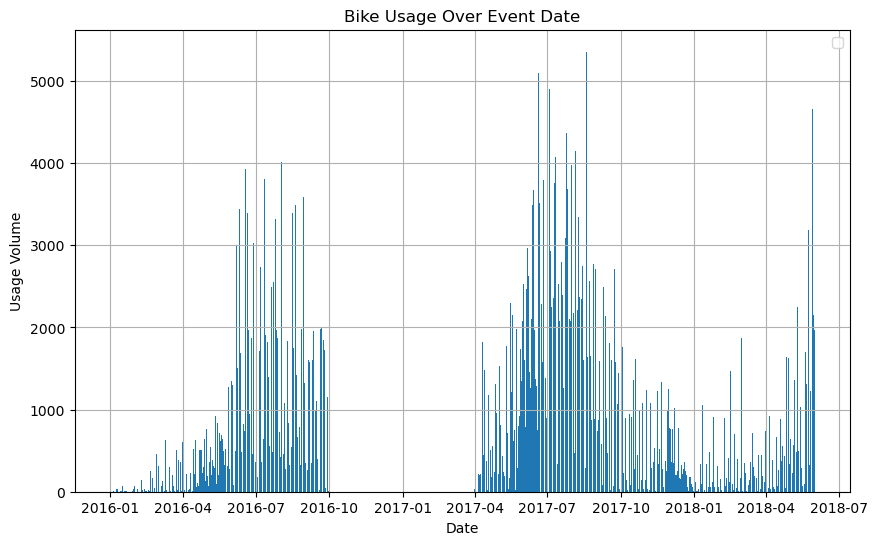

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))


plt.bar(x = event_usage['date_event'], height = event_usage["usage volumn"])


plt.xlabel('Date')
plt.ylabel('Usage Volume')
plt.title('Bike Usage Over Event Date')
plt.legend()
plt.grid()
plt.show()

A7: At the very beginning, we expected a strong positive correlation between Citibike usage and the occurrence of events. While this correlation is evident on most days, there are instances where it appears to be nonexistent. On days with a positive correlation, events such as festivals, concerts, or sports games may attract large crowds to specific locations, leading to increased demand for transportation options like Citibike. Attendees may prefer Citibike for its convenience, flexibility, and ability to navigate through crowded areas more easily compared to other modes of transportation. Conversely, on days with zero correlation, factors such as inclement weather or inconvenient event locations may deter individuals from biking to the event venue, prompting them to opt for alternative transportation options.

# Bonny

In [29]:
green_taxi.limit(3).toPandas()

24/04/27 17:19:35 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,vendor_id,pickup_datetime,dropoff_datetime,store_and_fwd_flag,rate_code,passenger_count,trip_distance,fare_amount,extra,mta_tax,...,trip_type,imp_surcharge,pickup_location_id,dropoff_location_id,data_file_year,data_file_month,year,month,hour,label
0,1,2017-01-21 11:34:53,2017-01-21 12:02:04,N,1.0,1,12.50,35.5,0.0,0.5,...,1.0,0.3,65,159,2017,1,2017,1,11,green_taxi
1,2,2017-01-25 07:52:13,2017-01-25 08:06:19,N,1.0,1,3.62,14.0,0.0,0.5,...,1.0,0.3,153,116,2017,1,2017,1,7,green_taxi
2,2,2017-01-03 11:59:52,2017-01-03 12:06:53,N,1.0,1,0.92,6.5,0.0,0.5,...,1.0,0.3,74,42,2017,1,2017,1,11,green_taxi


In [44]:
from pyspark.sql import functions as F
green_taxi = green_taxi.withColumn("pickup_date", F.to_date("pickup_datetime"))\
                       .withColumn("dropoff_date", F.to_date("dropoff_datetime"))

In [50]:
green_weather = green_taxi.join(weather,green_taxi['pickup_date'] == weather['date_weather'],how ='left')
green_weather = green_weather.drop("date_weather")
green_weather.limit(20).toPandas()

,vendor_id,pickup_datetime,dropoff_datetime,store_and_fwd_flag,rate_code,passenger_count,trip_distance,fare_amount,extra,mta_tax,...,month,hour,label,pickup_date,dropoff_date,PRCP,SNOW,SNWD,TMIN,TMAX
0,1,2017-01-21 11:34:53,2017-01-21 12:02:04,N,1.0,1,12.50,35.5,0.0,0.5,...,1,11,green_taxi,2017-01-21,2017-01-21,0.00,0.0,0.0,41,49
1,2,2017-01-25 07:52:13,2017-01-25 08:06:19,N,1.0,1,3.62,14.0,0.0,0.5,...,1,7,green_taxi,2017-01-25,2017-01-25,0.00,0.0,0.0,36,51
2,2,2017-01-03 11:59:52,2017-01-03 12:06:53,N,1.0,1,0.92,6.5,0.0,0.5,...,1,11,green_taxi,2017-01-03,2017-01-03,0.58,0.0,0.0,39,43
3,2,2017-01-08 07:24:03,2017-01-08 07:51:20,N,1.0,1,18.01,48.5,0.0,0.5,...,1,7,green_taxi,2017-01-08,2017-01-08,0.00,0.0,3.9,16,25
4,1,2017-01-31 15:31:49,2017-01-31 15:42:38,N,1.0,1,1.90,9.5,0.0,0.5,...,1,15,green_taxi,2017-01-31,2017-01-31,0.06,1.0,0.0,26,34
5,2,2017-01-21 15:23:40,2017-01-21 15:29:48,N,1.0,1,1.47,7.0,0.0,0.5,...,1,15,green_taxi,2017-01-21,2017-01-21,0.00,0.0,0.0,41,49
6,2,2017-01-08 19:57:59,2017-01-08 20:05:08,N,1.0,1,1.23,7.0,0.0,0.5,...,1,19,green_taxi,2017-01-08,2017-01-08,0.00,0.0,3.9,16,25
7,2,2017-01-15 10:24:07,2017-01-15 10:30:29,N,1.0,1,1.20,6.0,0.0,0.5,...,1,10,green_taxi,2017-01-15,2017-01-15,0.00,0.0,1.2,30,38
8,2,2017-02-24 15:42:10,2017-02-24 15:52:28,N,1.0,1,1.65,9.0,0.0,0.5,...,2,15,green_taxi,2017-02-24,2017-02-24,0.00,0.0,0.0,58,70
9,2,2017-02-06 09:06:04,2017-02-06 09:21:07,N,1.0,1,2.32,12.0,0.0,0.5,...,2,9,green_taxi,2017-02-06,2017-02-06,0.00,0.0,0.0,36,49


In [33]:
daily_count = green_weather.where(F.col('year').isin([2016, 2017, 2018]))\
                                  .groupBy("pickup_date") \
                                  .count() \
                                  .orderBy("pickup_date") \
                                  .withColumnRenamed("pickup_date","date")

In [34]:
daily_count.toPandas()

,date,count
0,2016-01-01,64398
1,2016-01-02,46958
2,2016-01-03,44270
3,2016-01-04,43740
4,2016-01-05,42342
...,...,...
1091,2018-12-27,20710
1092,2018-12-28,21146
1093,2018-12-29,20751
1094,2018-12-30,18139


## temperature

In [36]:
temp = green_weather.where(F.col('year').isin([2016, 2017, 2018])).select('pickup_date','TMIN','TMAX')
temp = temp.groupby("pickup_date").agg(F.avg(F.col("TMIN")),F.avg(F.col("TMAX"))).orderBy("pickup_date")

temp_all = temp.join(daily_count,temp['pickup_date']== daily_count['date'],how ='left')
temp_all = temp_all.drop("pickup_date").toPandas()
temp_all["avg_temp"] = (temp_all["avg(TMIN)"] + temp_all["avg(TMAX)"]) / 2
temp_all.head()

,avg(TMIN),avg(TMAX),date,count,avg_temp
0,55.0,76.0,2017-09-11,25277,65.5
1,69.0,82.0,2017-08-11,31270,75.5
2,39.0,52.0,2016-03-01,45348,45.5
3,56.0,69.0,2018-05-28,17588,62.5
4,72.0,86.0,2018-08-10,24583,79.0


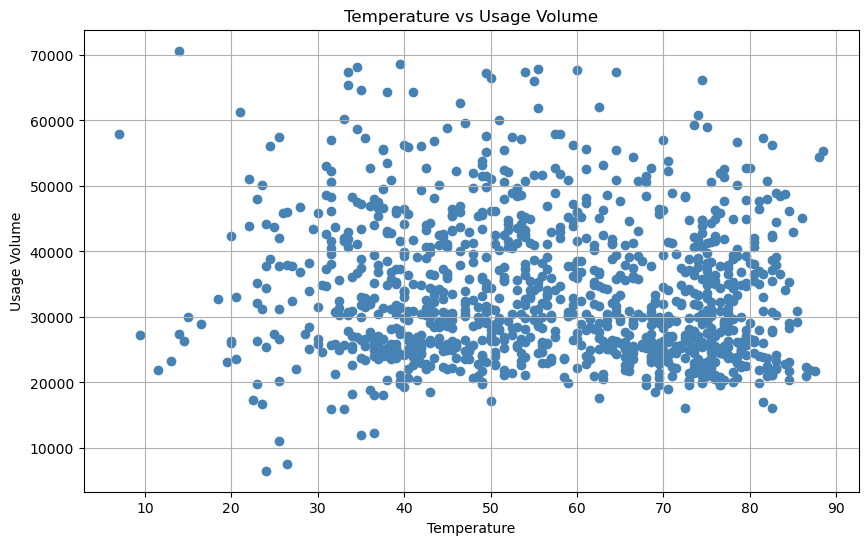

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.scatter(temp_all["avg_temp"], temp_all["count"], color='steelblue')

plt.xlabel('Temperature')
plt.ylabel('Usage Volume')
plt.title('Temperature vs Usage Volume')
plt.grid()
plt.show()

## Snow

In [40]:
snow = green_weather.where(F.col('year').isin([2016, 2017, 2018])).select('pickup_date','SNOW')
snow = snow.groupby("pickup_date").agg(F.avg(F.col("SNOW")).alias('Average Snow')).orderBy("pickup_date")

snow_all = snow.join(daily_count,snow['pickup_date']== daily_count['date'],how ='left')
snow_all = snow_all.drop("pickup_date").toPandas()
snow_all.head()

,Average Snow,date,count
0,0.0,2017-08-11,31270
1,0.0,2017-09-11,25277
2,0.0,2016-03-01,45348
3,0.0,2018-05-28,17588
4,0.0,2018-08-10,24583


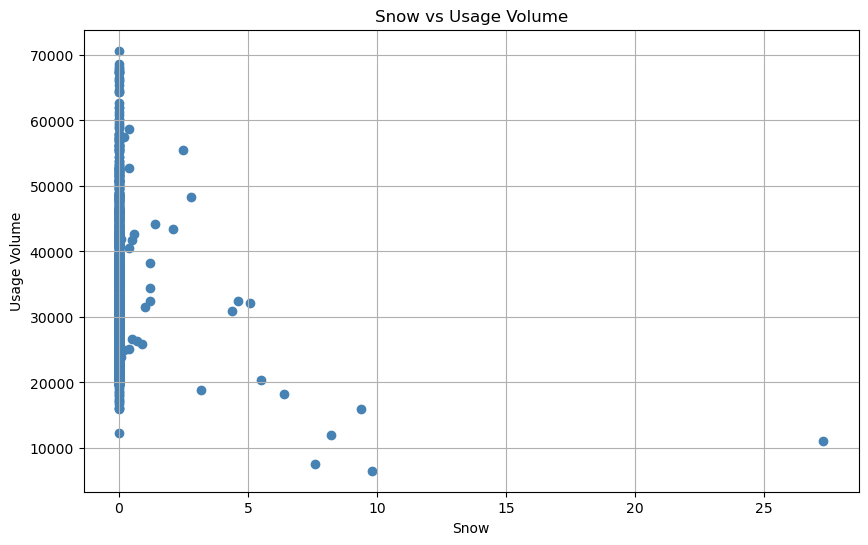

In [41]:
plt.figure(figsize=(10, 6))

plt.scatter(snow_all["Average Snow"], snow_all["count"], color='steelblue')

plt.xlabel('Snow')
plt.ylabel('Usage Volume')
plt.title('Snow vs Usage Volume')
plt.grid()
plt.show()

In [42]:
snow_true = snow.where(F.col('Average Snow') != 0).withColumn('snow_indicator',lit('snowing'))
snow_true = snow_true.join(daily_count,snow_true['pickup_date']== daily_count['date'],how ='left')
snow_true = snow_true.groupby("snow_indicator").agg(F.avg(F.col("count")).alias('average count'))
snow_true_count = snow_true.select("snow_indicator","average count").toPandas()

snow_false = snow.where(F.col('Average Snow') == 0).withColumn('snow_indicator',lit('not snowing'))
snow_false = snow_false.join(daily_count,snow_false['pickup_date']== daily_count['date'],how ='left')
snow_false = snow_false.groupby("snow_indicator").agg(F.avg(F.col("count")).alias('average count'))
snow_false_count = snow_false.select("snow_indicator","average count").toPandas()

In [51]:
import pandas as pd
snow_result = pd.concat([snow_true_count, snow_false_count], axis=0)
snow_result.reset_index(drop = True,inplace=True)

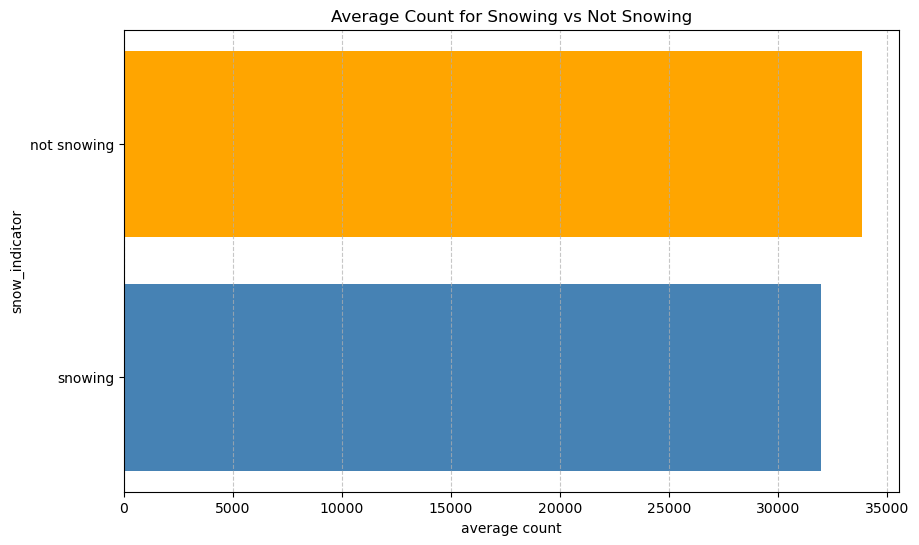

In [52]:
plt.figure(figsize=(10, 6))
plt.barh(snow_result["snow_indicator"],snow_result["average count"] ,color=['steelblue', 'orange'])

plt.xlabel('average count')
plt.ylabel('snow_indicator')
plt.title('Average Count for Snowing vs Not Snowing')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

## precipitation

In [53]:
prcp = green_weather.where(F.col('year').isin([2016, 2017, 2018])).select('pickup_date','PRCP')
prcp = prcp.groupby("pickup_date").agg(F.avg(F.col("PRCP")).alias("average precipitation")).orderBy("pickup_date")

prcp_all = prcp.join(daily_count,prcp['pickup_date']== daily_count['date'],how ='left')
prcp_all = prcp_all.drop("pickup_date").toPandas()
prcp_all.head()

,average precipitation,date,count
0,0.0,2017-09-11,25277
1,0.0,2017-08-11,31270
2,0.0,2016-03-01,45348
3,0.0,2018-05-28,17588
4,0.0,2018-08-10,24583


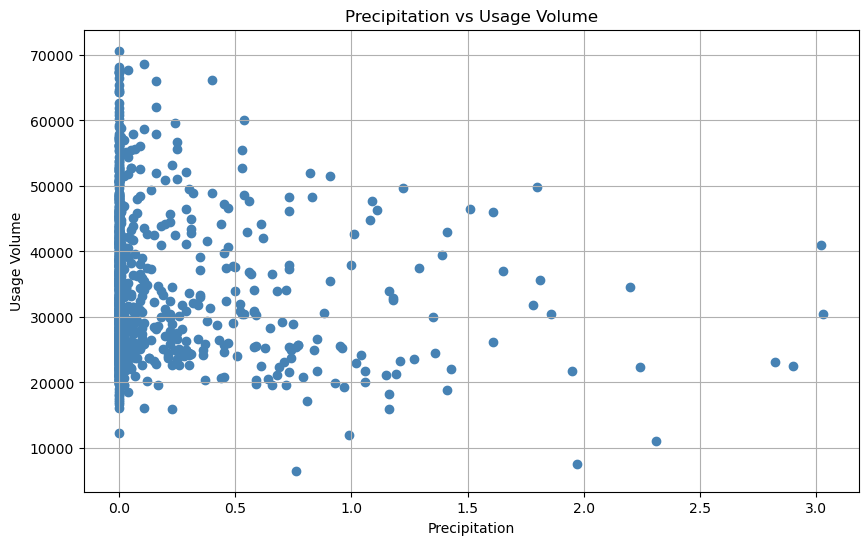

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.scatter(prcp_all["average precipitation"], prcp_all["count"], color='steelblue')

plt.xlabel('Precipitation')
plt.ylabel('Usage Volume')
plt.title('Precipitation vs Usage Volume')
plt.grid()
plt.show()

In [55]:
prcp_true = prcp.where(F.col('average precipitation') != 0).withColumn('prcp_indicator',lit('raining'))
prcp_true = prcp_true.join(daily_count,prcp_true['pickup_date']== daily_count['date'],how ='left')
prcp_true = prcp_true.groupby("prcp_indicator").agg(F.avg(F.col("count")).alias('average count'))
prcp_true_count = prcp_true.select("prcp_indicator","average count").toPandas()

prcp_false = prcp.where(F.col('average precipitation') == 0).withColumn('prcp_indicator',lit('not raining'))
prcp_false = prcp_false.join(daily_count,prcp_false['pickup_date']== daily_count['date'],how ='left')
prcp_false = prcp_false.groupby("prcp_indicator").agg(F.avg(F.col("count")).alias('average count'))
prcp_false_count = prcp_false.select("prcp_indicator","average count").toPandas()

In [56]:
import pandas as pd
prcp_result = pd.concat([prcp_true_count, prcp_false_count], axis=0)
prcp_result.reset_index(drop = True,inplace=True)

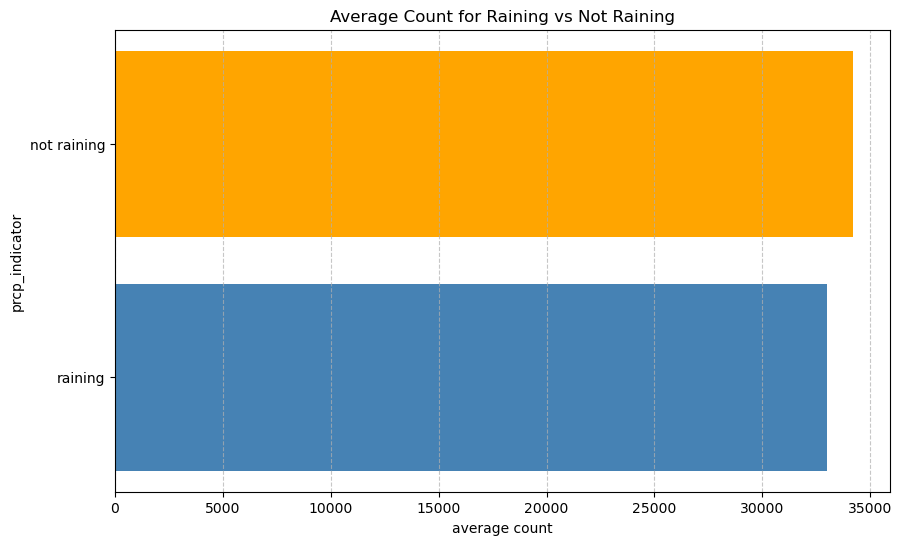

In [57]:
plt.figure(figsize=(10, 6))
plt.barh(prcp_result["prcp_indicator"],prcp_result["average count"] ,color=['steelblue', 'orange'])

plt.xlabel('average count')
plt.ylabel('prcp_indicator')
plt.title('Average Count for Raining vs Not Raining')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

## weekly usage

In [93]:
from pyspark.sql.functions import date_format, col, when, monotonically_increasing_id, count, sum, lit
green_taxi = green_taxi.withColumn('day/end', date_format('pickup_date', 'EEEE')) \
                   .withColumn("week end/day",
                              when(col("day/end").isin("Monday", "Tuesday", "Wednesday", "Thursday", "Friday"), "weekday")
                              .when(col("day/end").isin("Saturday","Sunday"), "weekend") 
                              ) 

In [94]:
dayend_green = green_taxi.groupBy("week end/day","hour").count().orderBy("week end/day","hour").toPandas()

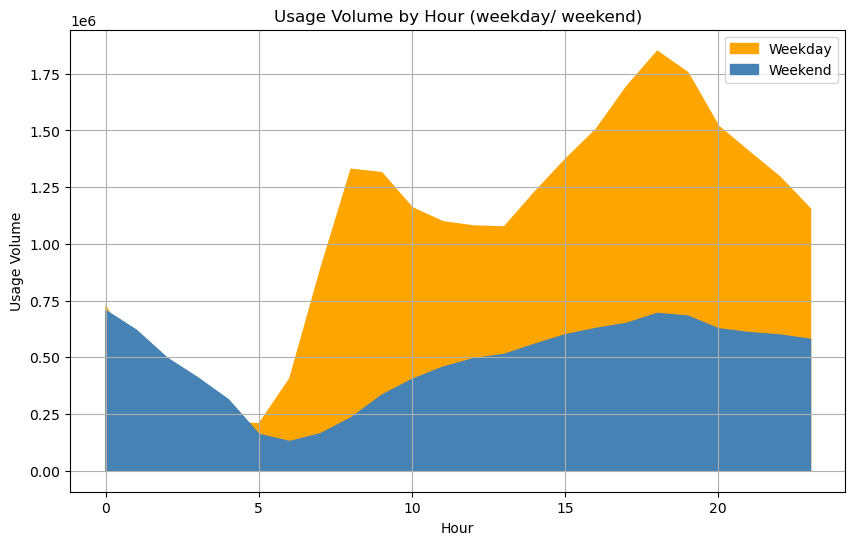

In [95]:
plt.figure(figsize=(10, 6))

weekday_day = dayend_green[dayend_green['week end/day'] == 'weekday']
weekend_end = dayend_green[dayend_green['week end/day'] == 'weekend']

    # CHatGPT: .fill_between function is the one I ask GhatGPT
    # used to fill the area between two horizontal curves
plt.fill_between(weekday_day['hour'], weekday_day['count'], color='orange', label='Weekday')
plt.fill_between(weekend_end['hour'], weekend_end['count'], color='steelblue', label='Weekend')

plt.xlabel('Hour')
plt.ylabel('Usage Volume')
plt.title('Usage Volume by Hour (weekday/ weekend)')
plt.legend()
plt.grid()
plt.show()

In [96]:
week_green = green_taxi.groupBy("day/end","hour").count().orderBy("day/end","hour").toPandas()

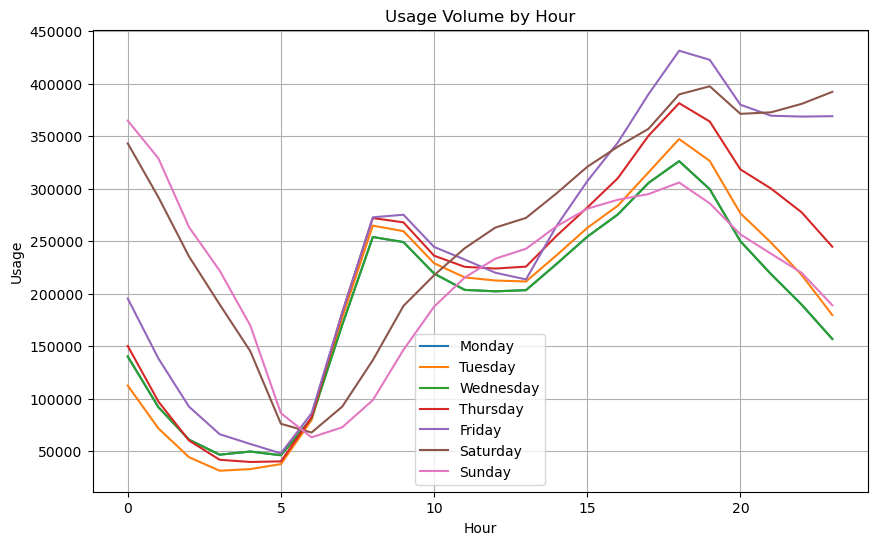

In [98]:
plt.figure(figsize=(10, 6))

mon_green = week_green[week_green['day/end'] == 'Monday']
tue_green = week_green[week_green['day/end'] == 'Tuesday']
wed_green = week_green[week_green['day/end'] == 'Wednesday']
thu_green = week_green[week_green['day/end'] == 'Thursday']
fri_green = week_green[week_green['day/end'] == 'Friday']
sat_green = week_green[week_green['day/end'] == 'Saturday']
sun_green = week_green[week_green['day/end'] == 'Sunday']


plt.plot(mon_green['hour'], mon_green['count'],label='Monday')
plt.plot(tue_green['hour'], tue_green['count'],label='Tuesday')
plt.plot(wed_green['hour'], mon_green['count'],label='Wednesday')
plt.plot(thu_green['hour'], thu_green['count'],label='Thursday')
plt.plot(fri_green['hour'], fri_green['count'],label='Friday')
plt.plot(sat_green['hour'], sat_green['count'],label='Saturday')
plt.plot(sun_green['hour'], sun_green['count'],label='Sunday')

plt.xlabel('Hour')
plt.ylabel('Usage')
plt.title('Usage Volume by Hour')
plt.legend()
plt.grid()
plt.show()

## Revenue

In [64]:
payment_type_revenue = green_taxi.where(F.col('payment_type').isNotNull())\
                  .groupBy('payment_type') \
                  .agg(F.avg(F.col("total_amount")).alias('average fee')) \
                  .orderBy('payment_type', ascending=True) \
                  .toPandas()

In [65]:
payment_type_mapping = {
    1: 'Credit Card',
    2: 'Cash',
    3: 'No Charge',
    4: 'Dispute',
    5: 'Unknown'
}

payment_type_revenue['payment_type'] = payment_type_revenue['payment_type'].replace(payment_type_mapping)

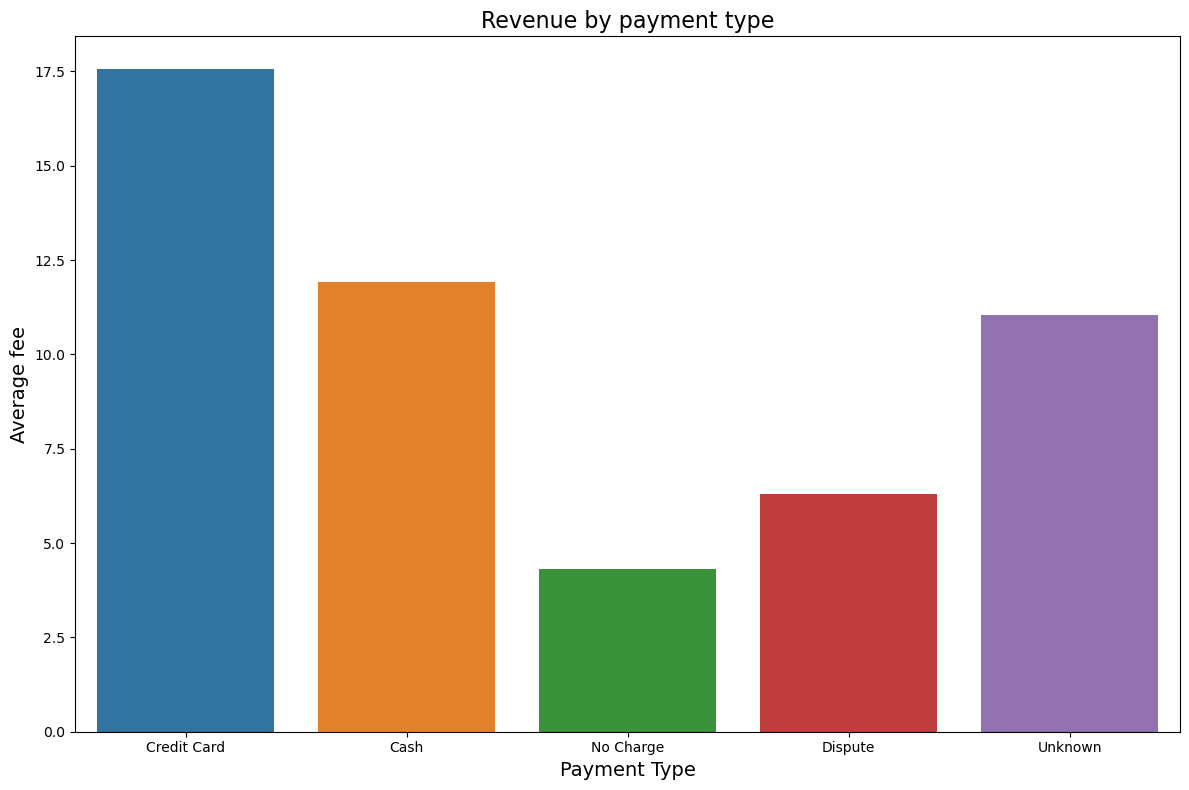

In [66]:
import seaborn as sns
plt.figure(figsize=(12, 8))  
barplot = sns.barplot(
    x='payment_type', 
    y='average fee', 
    data=payment_type_revenue, 
)
plt.title('Revenue by payment type', fontsize=16)
plt.xlabel('Payment Type', fontsize=14)
plt.ylabel('Average fee', fontsize=14) 

plt.tight_layout()
plt.show()

In [81]:
dayend_revenue = green_taxi.where(F.col('total_amount').isNotNull()).groupBy("week end/day","hour").agg(F.avg(F.col("total_amount")).alias('average fee')).orderBy("week end/day","hour").toPandas()

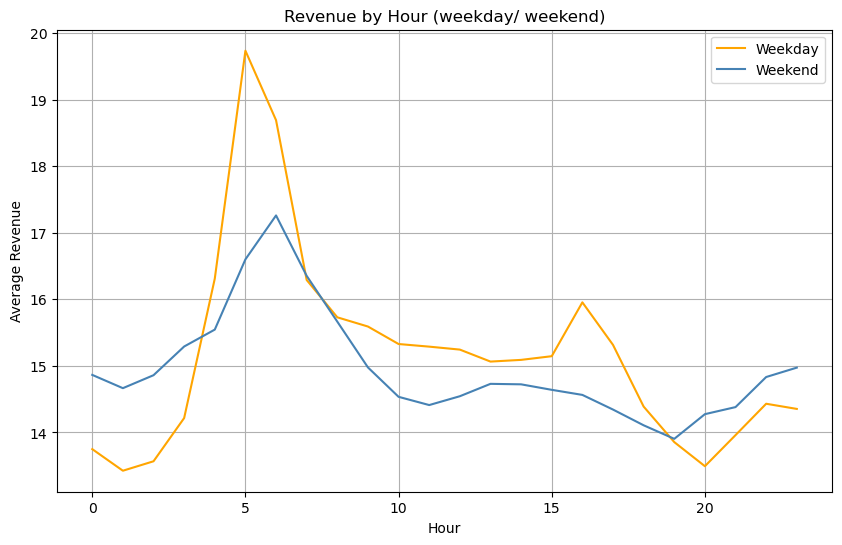

In [82]:
plt.figure(figsize=(10, 6))

weekday_day_revenue = dayend_revenue[dayend_revenue['week end/day'] == 'weekday']
weekend_end_revenue = dayend_revenue[dayend_revenue['week end/day'] == 'weekend']

plt.plot(weekday_day_revenue['hour'], weekday_day_revenue['average fee'], color='orange', label='Weekday')
plt.plot(weekend_end_revenue['hour'], weekend_end_revenue['average fee'], color='steelblue', label='Weekend')

plt.xlabel('Hour')
plt.ylabel('Average Revenue')
plt.title('Revenue by Hour (weekday/ weekend)')
plt.legend()
plt.grid()
plt.show()

In [80]:
week_revenue = green_taxi.where(F.col('total_amount').isNotNull()).groupBy("day/end","hour").agg(F.avg(F.col("total_amount")).alias('average fee')).orderBy("day/end","hour").toPandas()

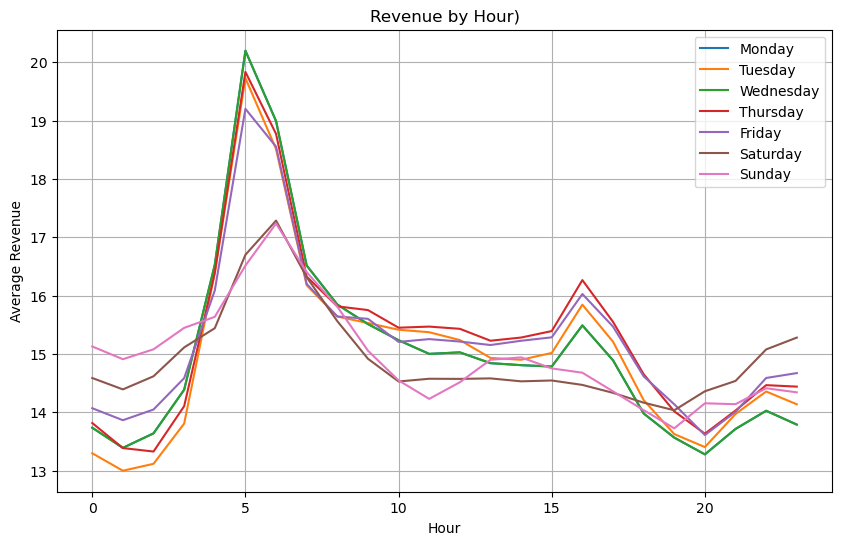

In [83]:
plt.figure(figsize=(10, 6))

mon_revenue = week_revenue[week_revenue['day/end'] == 'Monday']
tue_revenue = week_revenue[week_revenue['day/end'] == 'Tuesday']
wed_revenue = week_revenue[week_revenue['day/end'] == 'Wednesday']
thu_revenue = week_revenue[week_revenue['day/end'] == 'Thursday']
fri_revenue = week_revenue[week_revenue['day/end'] == 'Friday']
sat_revenue = week_revenue[week_revenue['day/end'] == 'Saturday']
sun_revenue = week_revenue[week_revenue['day/end'] == 'Sunday']


plt.plot(mon_revenue['hour'], mon_revenue['average fee'],label='Monday')
plt.plot(tue_revenue['hour'], tue_revenue['average fee'],label='Tuesday')
plt.plot(wed_revenue['hour'], mon_revenue['average fee'],label='Wednesday')
plt.plot(thu_revenue['hour'], thu_revenue['average fee'],label='Thursday')
plt.plot(fri_revenue['hour'], fri_revenue['average fee'],label='Friday')
plt.plot(sat_revenue['hour'], sat_revenue['average fee'],label='Saturday')
plt.plot(sun_revenue['hour'], sun_revenue['average fee'],label='Sunday')

plt.xlabel('Hour')
plt.ylabel('Average Revenue')
plt.title('Revenue by Hour)')
plt.legend()
plt.grid()
plt.show()

In [71]:
month_revenue = green_taxi.where(F.col('total_amount').isNotNull())\
                  .groupBy('month') \
                  .agg(F.avg('total_amount').alias('Average fee')) \
                  .orderBy('month', ascending=True) \
                  .toPandas()

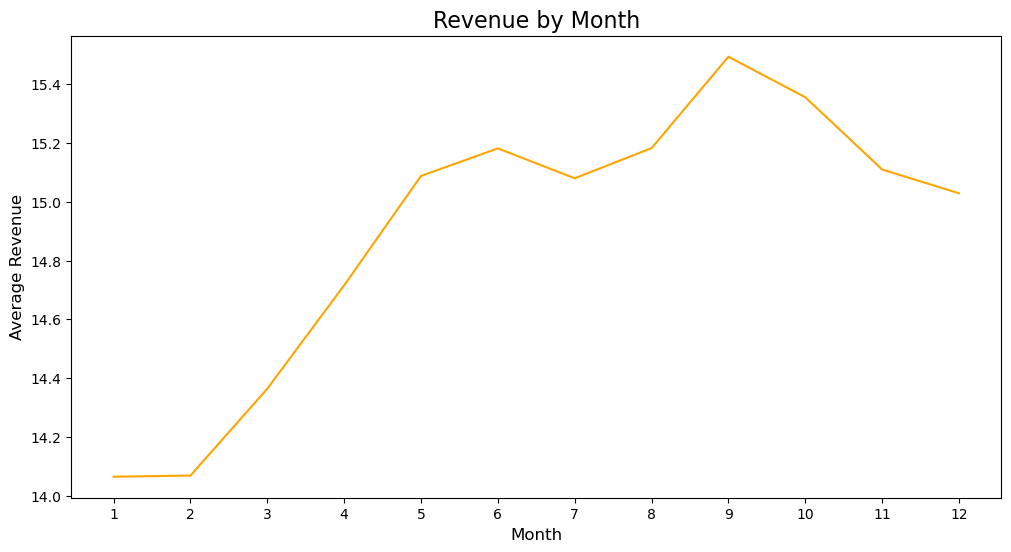

In [74]:
import seaborn as sns

plt.figure(figsize=(12, 6))
plt.plot(month_revenue['month'], month_revenue['Average fee'], color='orange')

# Adding title and labels
plt.title('Revenue by Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Revenue', fontsize=12)
plt.xticks(range(1, 13))  

# Show the plot
plt.show()

## Tips

In [87]:
payment_type_tips = green_taxi.where(F.col('payment_type').isNotNull())\
                  .groupBy('payment_type') \
                  .agg(F.avg(F.col("tip_amount")).alias('average tip')) \
                  .orderBy('payment_type', ascending=True) \
                  .toPandas()

In [90]:
payment_type_tips['payment_type'] = payment_type_tips['payment_type'].replace(payment_type_mapping)

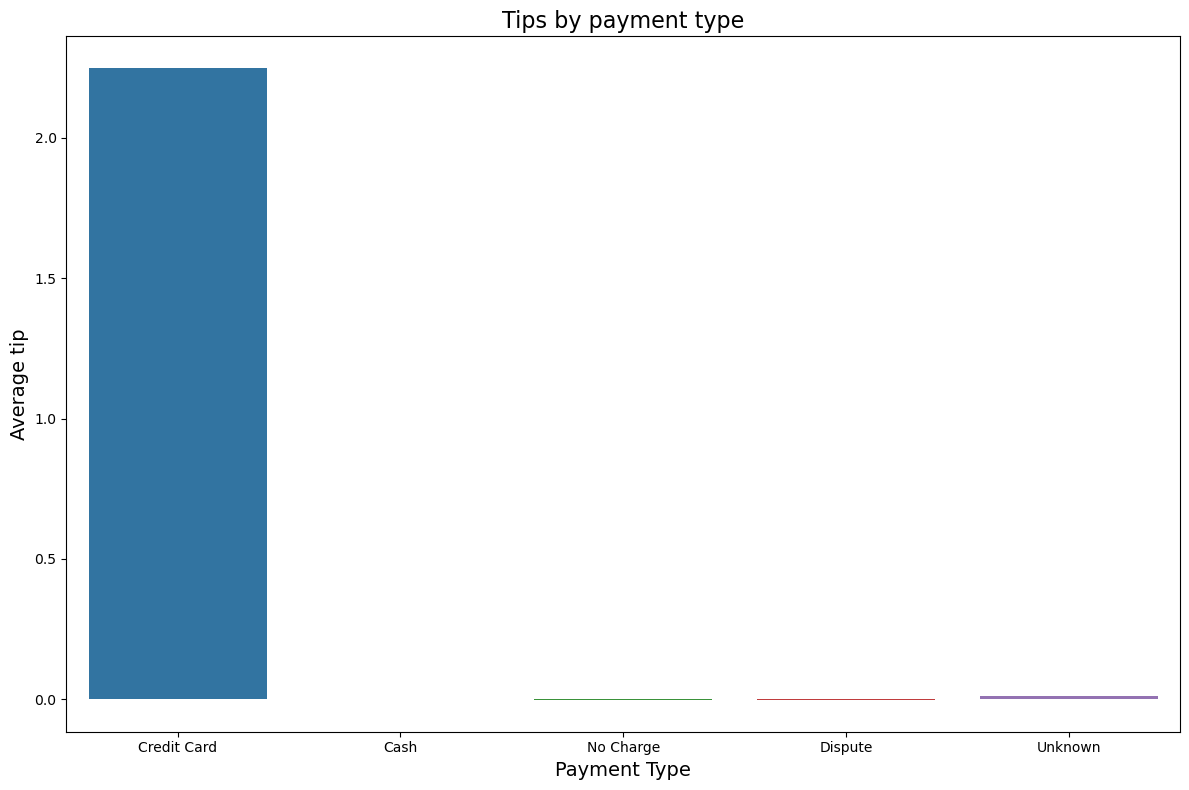

In [91]:
import seaborn as sns
plt.figure(figsize=(12, 8))  
barplot = sns.barplot(
    x='payment_type', 
    y='average tip', 
    data=payment_type_tips, 
)
plt.title('Tips by payment type', fontsize=16)
plt.xlabel('Payment Type', fontsize=14)
plt.ylabel('Average tip', fontsize=14) 

plt.tight_layout()
plt.show()